## Install dependencies

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

In [5]:
conditions = ['human', 'chimp', 'macaque']
cond_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue']
color_dict = {'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'spatial_libd_human': 'tab:blue'}

# Load files

## Pseudobulks

### Load

In [6]:
dir_path = '../data/pseudobulks/'

In [7]:
os.listdir(dir_path)

['4spe_pb_mean_filt.h5ad',
 '4spe_pb_mean_filt_nor_mean.h5ad',
 'adults_mammals.h5ad',
 'pb_age.h5ad',
 'pb_age_sample_norm.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_mean_filtered.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

In [8]:
adata_pb = sc.read_h5ad(dir_path + 'adults_mammals.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 170 × 14611
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

## Marker genes

In [9]:
with open('results/markers.txt', 'r') as file:
    # load genesets
    marker_genes = list(map(lambda x: x.strip().split('\t\t'), file.readlines()))
    # filter out mouse genesets
    marker_genes = {el[0]:el[1].split('\t') for el in marker_genes if 'Human' in el[0]}

len(marker_genes)

222

## Background genes

In [10]:
with open('results/background_genes.txt', 'r') as file:
    background_genes = file.read().split(',')
len(background_genes)

7790

In [11]:
background_genes = adata_pb.var_names.intersection(background_genes)
len(background_genes)

7667

# Enrichment analysis (ALLEN)

## Preprocess data

Let's make pandas dataframe with expression data and leave only well-expressed genes

In [12]:
df_ssgsea = pd.DataFrame(adata_pb.X, columns=adata_pb.var_names, index=adata_pb.obs_names)
df_ssgsea = df_ssgsea[background_genes]

sample_order = dict()
for cond in ['human', 'chimp', 'macaque', '151']:
    samples = df_ssgsea.loc[df_ssgsea.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_laminar + order_wm
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque'] + sample_order['151']
df_ssgsea = df_ssgsea.loc[sample_order['all']]

df_ssgsea.head()

A1BG      AACS     AADAT     AAGAB      AAK1      AAMP  \
human_759_L1  0.144000  0.108000  0.086000  0.046000  0.180000  0.160000   
human_j12_L1  0.145015  0.063444  0.066465  0.072508  0.271903  0.181269   
human_j3_L1   0.190909  0.154545  0.263636  0.081818  0.263636  0.400000   
human_j4_L1   0.252101  0.159664  0.163866  0.088235  0.235294  0.281513   
human_j6_L1   0.067164  0.074627  0.097015  0.044776  0.134328  0.164179   

                  AAR2  AASDHPPT      AATF      AATK  ...   ZSCAN18   ZSCAN26  \
human_759_L1  0.050000  0.378000  0.032000  0.052000  ...  0.266000  0.042000   
human_j12_L1  0.060423  0.558912  0.063444  0.090634  ...  0.299094  0.048338   
human_j3_L1   0.127273  0.554545  0.145455  0.136364  ...  0.409091  0.036364   
human_j4_L1   0.126050  0.659664  0.054622  0.159664  ...  0.449580  0.067227   
human_j6_L1   0.067164  0.395522  0.052239  0.082090  ...  0.291045  0.037313   

                ZSWIM6    ZSWIM7    ZSWIM8      ZUP1    ZWILCH    ZYG11B  \
human_759_L1  0.092000  0.052000  0.050000  0.050000  0.056000  0.296000   
human_j12_L1  0.163142  0.111782  0.090634  0.048338  0.027190  0.601208   
human_j3_L1   0.145455  0.118182  0.172727  0.072727  0.090909  0.700000   
human_j4_L1   0.155462  0.138655  0.109244  0.071429  0.113445  0.630252   
human_j6_L1   0.134328  0.052239  0.104478  0.059701  0.037313  0.298507   

                   ZYX     ZZEF1  
human_759_L1  0.170000  0.038000  
human_j12_L1  0.208459  0.033233  
human_j3_L1   0.400000  0.263636  
human_j4_L1   0.394958  0.067227  
human_j6_L1   0.253731  0.052239  

[5 rows x 7667 columns]

## ssGSEA

In [13]:
ss = gseapy.ssgsea(
    data=df_ssgsea.T,
    gene_sets='Allen_Brain_Atlas_10x_scRNA_2021',
    outdir=None,
    min_size=3,
    sample_norm_method="rank",
    no_plot=True
)
ssGSEA_res = ss.res2d
ssGSEA_res.head()

Name                                 Term           ES  \
0       human_j12_L2             Mouse 203 L5 IT CTX down  3475.424215   
1        human_j6_L1             Mouse 203 L5 IT CTX down  3453.927762   
2  macaque_nb0904_L6  Human Inh L5-6 PVALB SST CRHR2 down   -3439.0352   
3    macaque_0701_L4  Human Inh L5-6 PVALB SST CRHR2 down -3429.314511   
4        chimp_j8_L4  Human Inh L5-6 PVALB SST CRHR2 down -3409.049838   

        NES  
0  0.502631  
1  0.499522  
2 -0.497369  
3 -0.495963  
4 -0.493032

We will work with normalized score from now on

In [14]:
nes = ssGSEA_res.pivot(index='Term', columns='Name', values='NES').astype(float)
nes = nes.loc[(nes.index.str.contains('Human')) & (nes.index.str.contains('up')), sample_order['all']]
nes.head(2)

Name                              human_759_L1  human_j12_L1  human_j3_L1  \
Term                                                                        
Human Astro L1 FGFR3 SERPINI2 up      0.288294      0.268735     0.183354   
Human Astro L1-6 FGFR3 AQP1 up        0.361278      0.326007     0.309125   

Name                              human_j4_L1  human_j6_L1  human_759_L2  \
Term                                                                       
Human Astro L1 FGFR3 SERPINI2 up     0.210249     0.199268      0.175762   
Human Astro L1-6 FGFR3 AQP1 up       0.324309     0.323989      0.300855   

Name                              human_j12_L2  human_j3_L2  human_j4_L2  \
Term                                                                       
Human Astro L1 FGFR3 SERPINI2 up      0.163360     0.098283     0.115115   
Human Astro L1-6 FGFR3 AQP1 up        0.253578     0.255457     0.261490   

Name                              human_j6_L2  ...  151509_WM  151510_WM  \
Term                                           ...                         
Human Astro L1 FGFR3 SERPINI2 up     0.122117  ...   0.186928   0.203062   
Human Astro L1-6 FGFR3 AQP1 up       0.260334  ...   0.256997   0.258868   

Name                              151669_WM  151670_WM  151671_WM  151672_WM  \
Term                                                                           
Human Astro L1 FGFR3 SERPINI2 up   0.192512   0.197027   0.156418   0.177647   
Human Astro L1-6 FGFR3 AQP1 up     0.282016   0.272206   0.236014   0.260606   

Name                              151673_WM  151674_WM  151675_WM  151676_WM  
Term                                                                          
Human Astro L1 FGFR3 SERPINI2 up   0.226873    0.22007   0.219650   0.230693  
Human Astro L1-6 FGFR3 AQP1 up     0.288325    0.28307   0.285905   0.297582  

[2 rows x 170 columns]

In [15]:
adata_ssgsea = an.AnnData(nes.T, obs=adata_pb.obs.loc[sample_order['all']])
adata_ssgsea

AnnData object with n_obs × n_vars = 170 × 104
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'

In [16]:
sc.pp.pca(adata_ssgsea)

computing PCA
    with n_comps=50
    finished (0:00:00)


computing PCA
    with n_comps=34
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


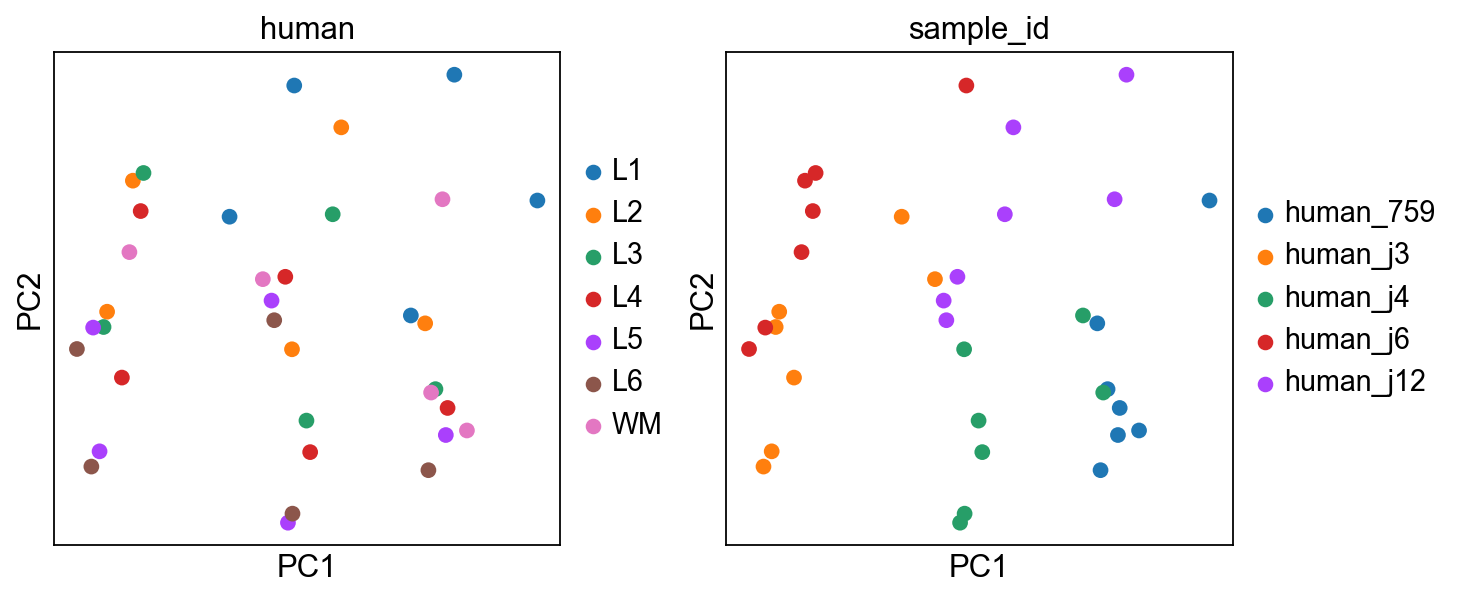

computing PCA
    with n_comps=30
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


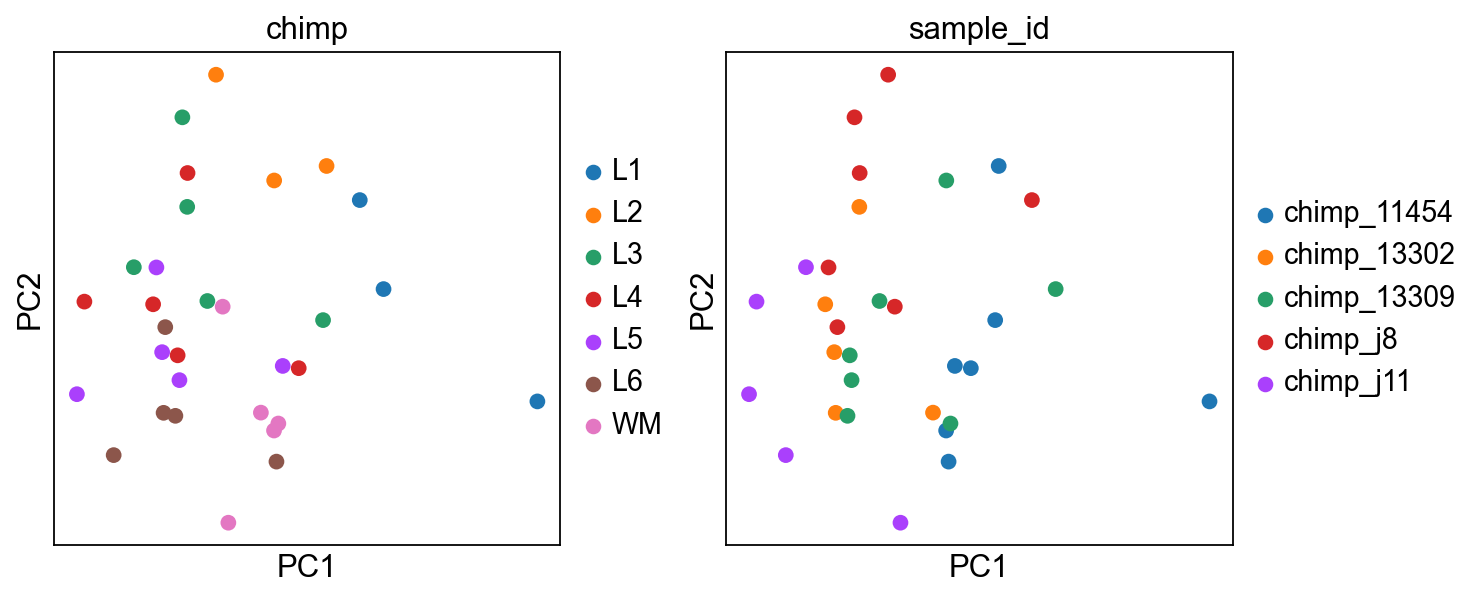

computing PCA
    with n_comps=27
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


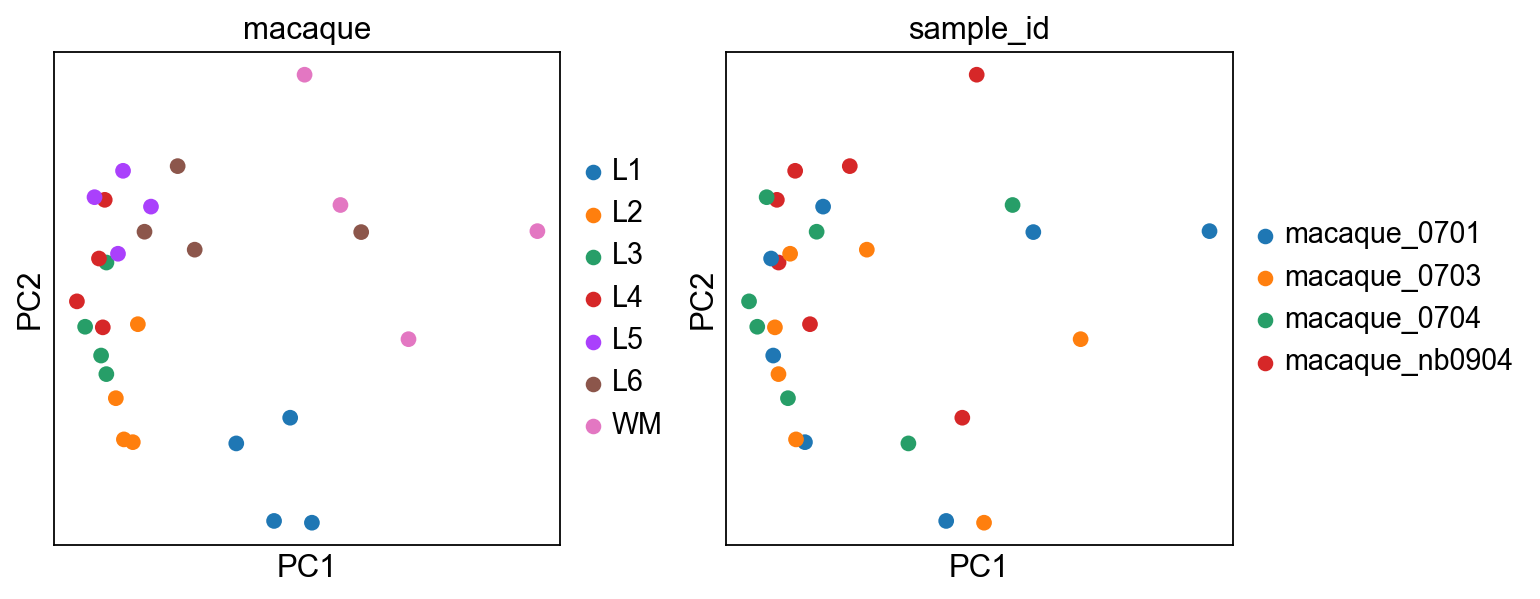

computing PCA
    with n_comps=50
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


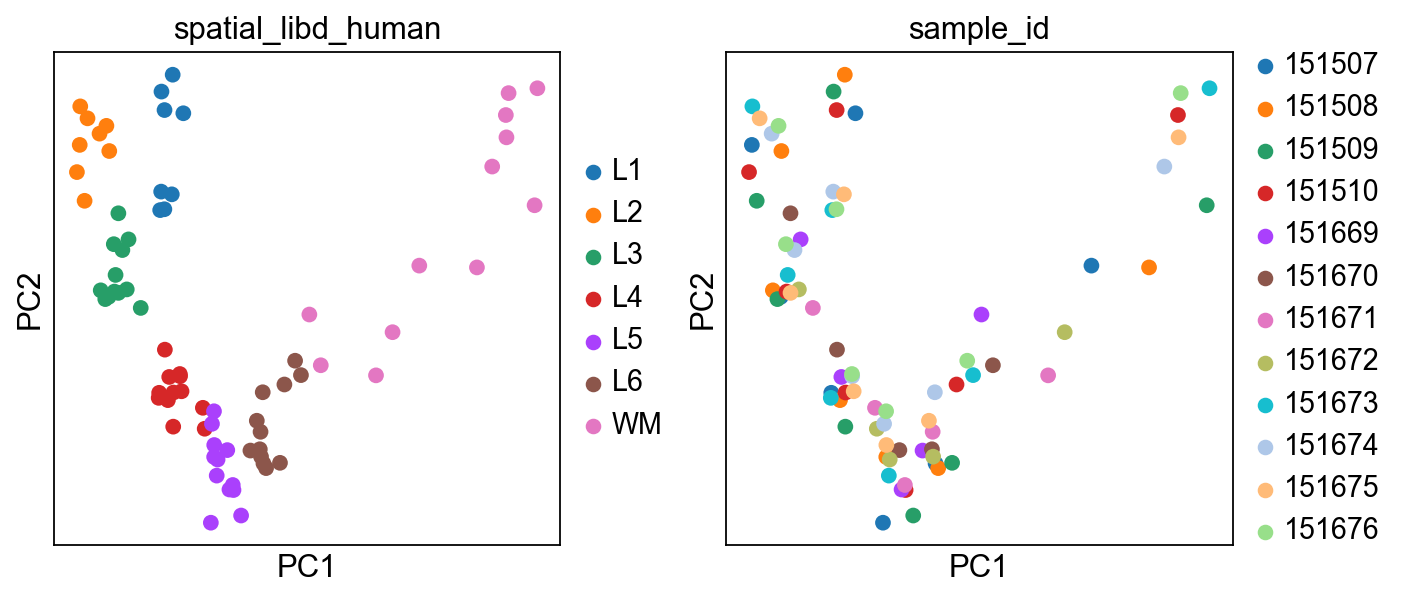

In [17]:
for cond in ['human', 'chimp', 'macaque', 'spatial_libd_human']:
    adata_cond = adata_ssgsea[adata_ssgsea.obs.condition == cond, :].copy()
    sc.pp.pca(adata_cond, return_info=False)
    sc.pl.pca(adata_cond, color=['layer', 'sample_id'], size=200, ncols=2, title=cond)

d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


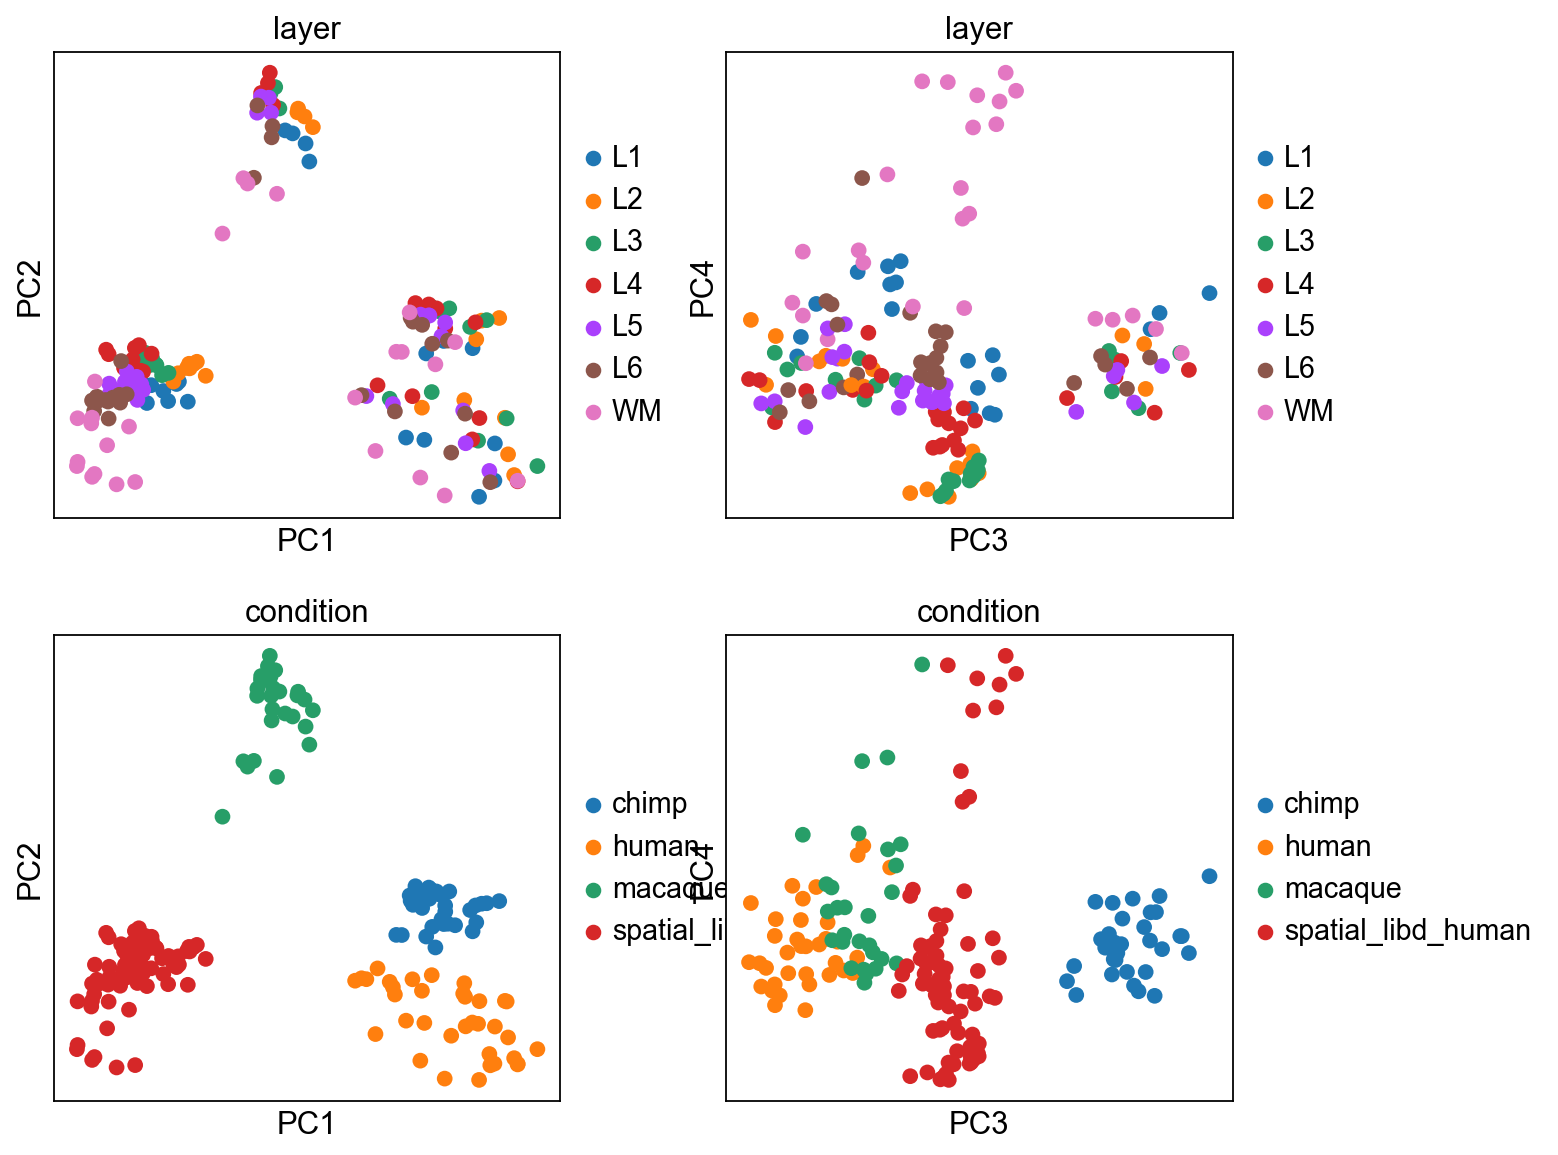

In [18]:
sc.pl.pca(adata_ssgsea, color=['layer', 'condition'], size=200, ncols=2, components = ['1,2','3,4'])

In [19]:
from scipy.stats import zscore

nes_zscore = nes.T
nes_zscore['sample_id'] = adata_ssgsea.obs.sample_id
nes_zscore = nes_zscore.groupby('sample_id', group_keys=False).apply(zscore)
nes_zscore.head()

Term          Human Astro L1 FGFR3 SERPINI2 up  \
Name                                             
human_759_L1                          2.396586   
human_j12_L1                          1.570616   
human_j3_L1                           1.274481   
human_j4_L1                           1.287658   
human_j6_L1                           2.047299   

Term          Human Astro L1-6 FGFR3 AQP1 up  Human Astro L1-6 FGFR3 PLCG1 up  \
Name                                                                            
human_759_L1                        2.334490                         2.377069   
human_j12_L1                        1.527191                         1.920827   
human_j3_L1                         0.973722                         1.187993   
human_j4_L1                         1.417209                         1.668489   
human_j6_L1                         2.011790                         2.091563   

Term          Human Endo L2-5 NOSTRIN SRGN up  Human Exc L2 LAMP5 KCNG3 up  \
Name                                                                         
human_759_L1                         1.877934                    -0.697125   
human_j12_L1                         1.069441                    -1.395880   
human_j3_L1                          1.256034                    -0.042443   
human_j4_L1                          0.371008                    -0.811309   
human_j6_L1                          1.957373                     0.520649   

Term          Human Exc L2 LINC00507 ATP7B up  \
Name                                            
human_759_L1                        -2.118238   
human_j12_L1                        -0.835747   
human_j3_L1                         -2.107891   
human_j4_L1                         -0.739821   
human_j6_L1                         -2.018812   

Term          Human Exc L2 LINC00507 GLRA3 up  \
Name                                            
human_759_L1                        -0.049683   
human_j12_L1                        -2.230276   
human_j3_L1                         -1.290022   
human_j4_L1                         -1.636942   
human_j6_L1                          1.085624   

Term          Human Exc L2-3 LINC00507 DSG3 up  Human Exc L2-3 RORB CCDC68 up  \
Name                                                                            
human_759_L1                         -1.193890                      -1.383260   
human_j12_L1                         -1.669602                      -1.672465   
human_j3_L1                           0.494301                      -0.773987   
human_j4_L1                          -0.846689                      -0.269207   
human_j6_L1                           1.337801                      -0.058330   

Term          Human Exc L3 LAMP5 CARM1P1 up  ...  \
Name                                         ...   
human_759_L1                       1.737622  ...   
human_j12_L1                       0.761205  ...   
human_j3_L1                        1.315708  ...   
human_j4_L1                       -0.362063  ...   
human_j6_L1                        1.864326  ...   

Term          Human Inh L5-6 SST PIK3CD up  Human Inh L5-6 VIP COL4A3 up  \
Name                                                                       
human_759_L1                      2.114760                      1.212524   
human_j12_L1                     -1.325390                      0.211903   
human_j3_L1                      -0.062122                      0.976338   
human_j4_L1                      -0.360552                      0.309264   
human_j6_L1                      -1.304709                      0.492991   

Term          Human Inh L6 SST TH up  Human Micro L1-6 TYROBP CD74 up  \
Name                                                                    
human_759_L1               -0.927073                         2.124337   
human_j12_L1               -1.489976                         0.434877   
human_j3_L1                 0.142728                        -1.450695   
human_j4_L1    

In [20]:
cell_type = ['Astro', 'Exc', 'Inh', 'Oligo']
unique_celltypes = ['VLMC', 'OPC', 'Micro', 'Endo']

In [21]:
from sklearn.decomposition import PCA
X = nes_zscore.T.values
pca = PCA(n_components=2)
X_transf = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.24050993 0.16158266]
[63.98594789 52.44637552]


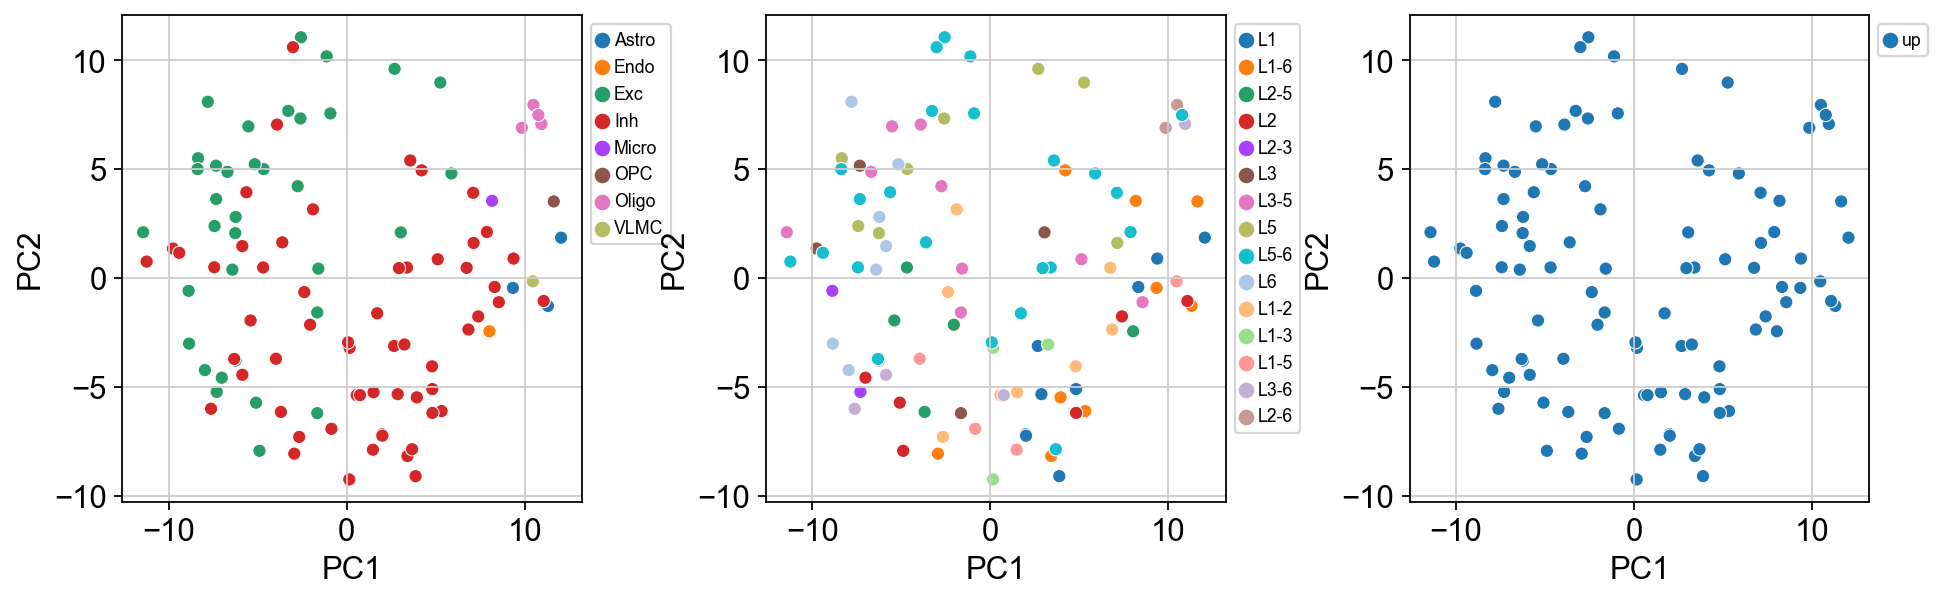

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4), gridspec_kw={'wspace': 0.4}, dpi=80)
pca_tr = pd.DataFrame(X_transf, index=nes_zscore.columns, columns=['PC1', 'PC2'])
pca_tr['major_ct'] = list(map(lambda x: x.split()[1], pca_tr.index))
pca_tr['layer'] = list(map(lambda x: x.split()[2], pca_tr.index))
pca_tr['direction'] = list(map(lambda x: x.split()[-1], pca_tr.index))
sns.scatterplot(pca_tr, x='PC1', y='PC2', hue='major_ct', ax=ax[0])
ax[0].legend(fontsize=2, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":8})
sns.scatterplot(pca_tr, x='PC1', y='PC2', hue='layer', ax=ax[1])
ax[1].legend(fontsize=2, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":8})
sns.scatterplot(pca_tr, x='PC1', y='PC2', hue='direction', ax=ax[2])
ax[2].legend(fontsize=2, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":8})

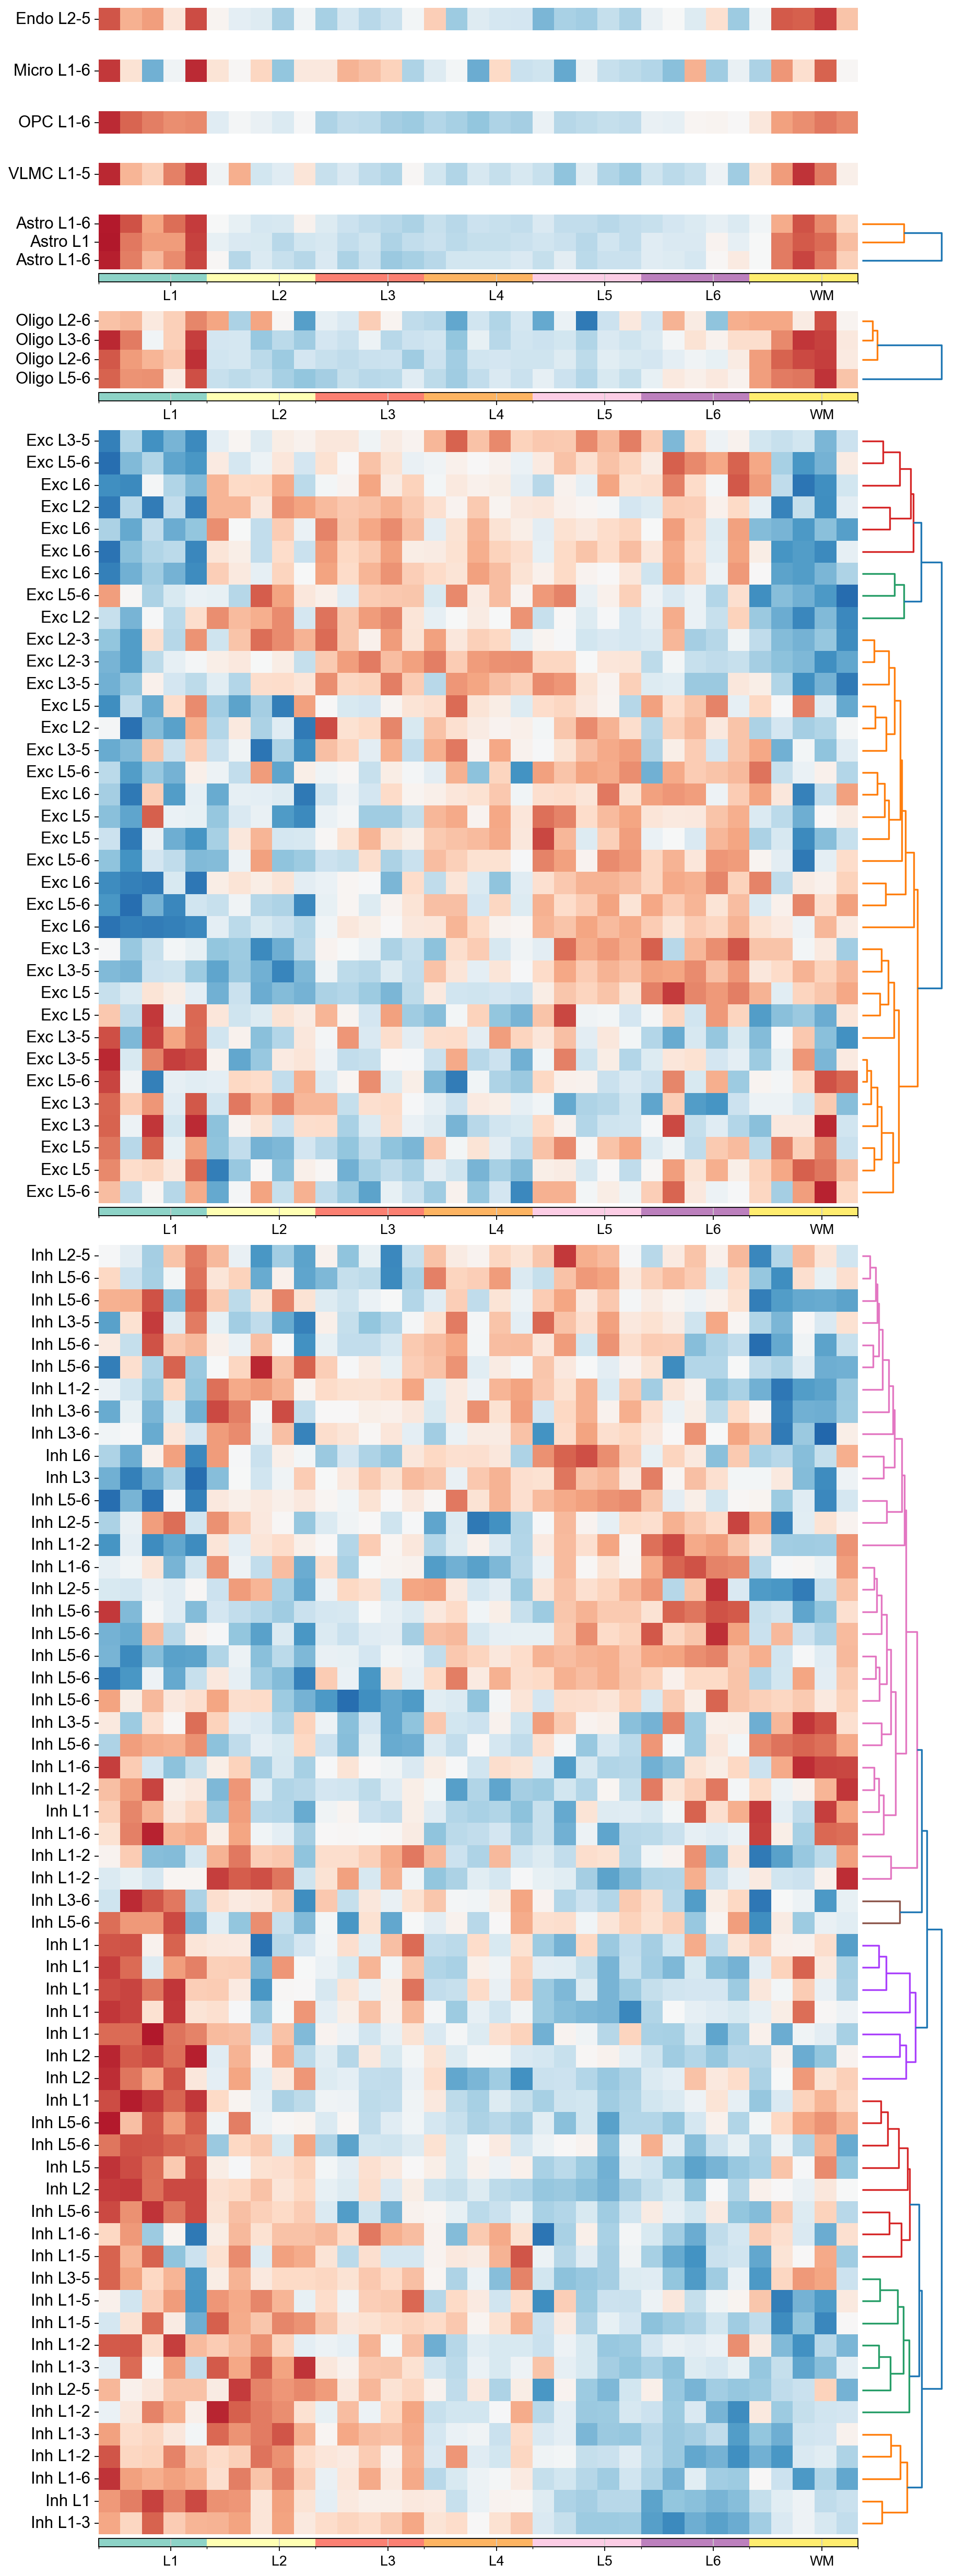

In [24]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from scipy.cluster.hierarchy import average, leaves_list, dendrogram
from scipy.spatial.distance import pdist

cell_type_counts = pca_tr.major_ct.value_counts(ascending=True).to_dict()
fig, axes = plt.subplots(len(cell_type_counts.values()), 1, figsize=(13, 40), height_ratios=cell_type_counts.values(), gridspec_kw={'hspace': 0.1}, dpi=80)

for ct, ax in zip(cell_type_counts.keys(), axes):
    celltype_ord = nes_zscore.columns.str.contains(ct)
    samp_ord = sample_order['human']
    df_sub = nes_zscore.loc[samp_ord, celltype_ord].T.copy()
    df_sub.index = df_sub.index.map(lambda x: ' '.join(x.split(' ')[1:3]))
    if ct in cell_type:
        linkage = average(pdist(df_sub.values, 'cosine'))
        index_ord = leaves_list(linkage)
        sns.heatmap(df_sub.iloc[index_ord, :], ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    else:
        sns.heatmap(df_sub, ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(False)
    ax.tick_params(axis="y", which="major", rotation=0)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size=1, pad=0.05)
    cax.axis('off')

    if ct in cell_type:
        dn = dendrogram(linkage, ax=cax, orientation='right')

        # vertical
        cax = divider.append_axes('bottom', size=0.1, pad=0.05)

        cmap = plt.get_cmap('Set3')
        cond_size = adata_ssgsea[samp_ord].obs.layer.value_counts().loc[layers].values
        cond_pos = cond_size.cumsum()
        bounds = [0] + list(cond_pos)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        fig.colorbar(
            mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
            cax=cax,
            ticks=bounds,
            orientation='horizontal',
            spacing='proportional'
        )

        cax.xaxis.set_major_locator(ticker.FixedLocator(cond_pos - cond_size / 3))
        cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
        cax.set_xticklabels(cax.get_xticklabels(), rotation=0, fontsize=12)
plt.show()

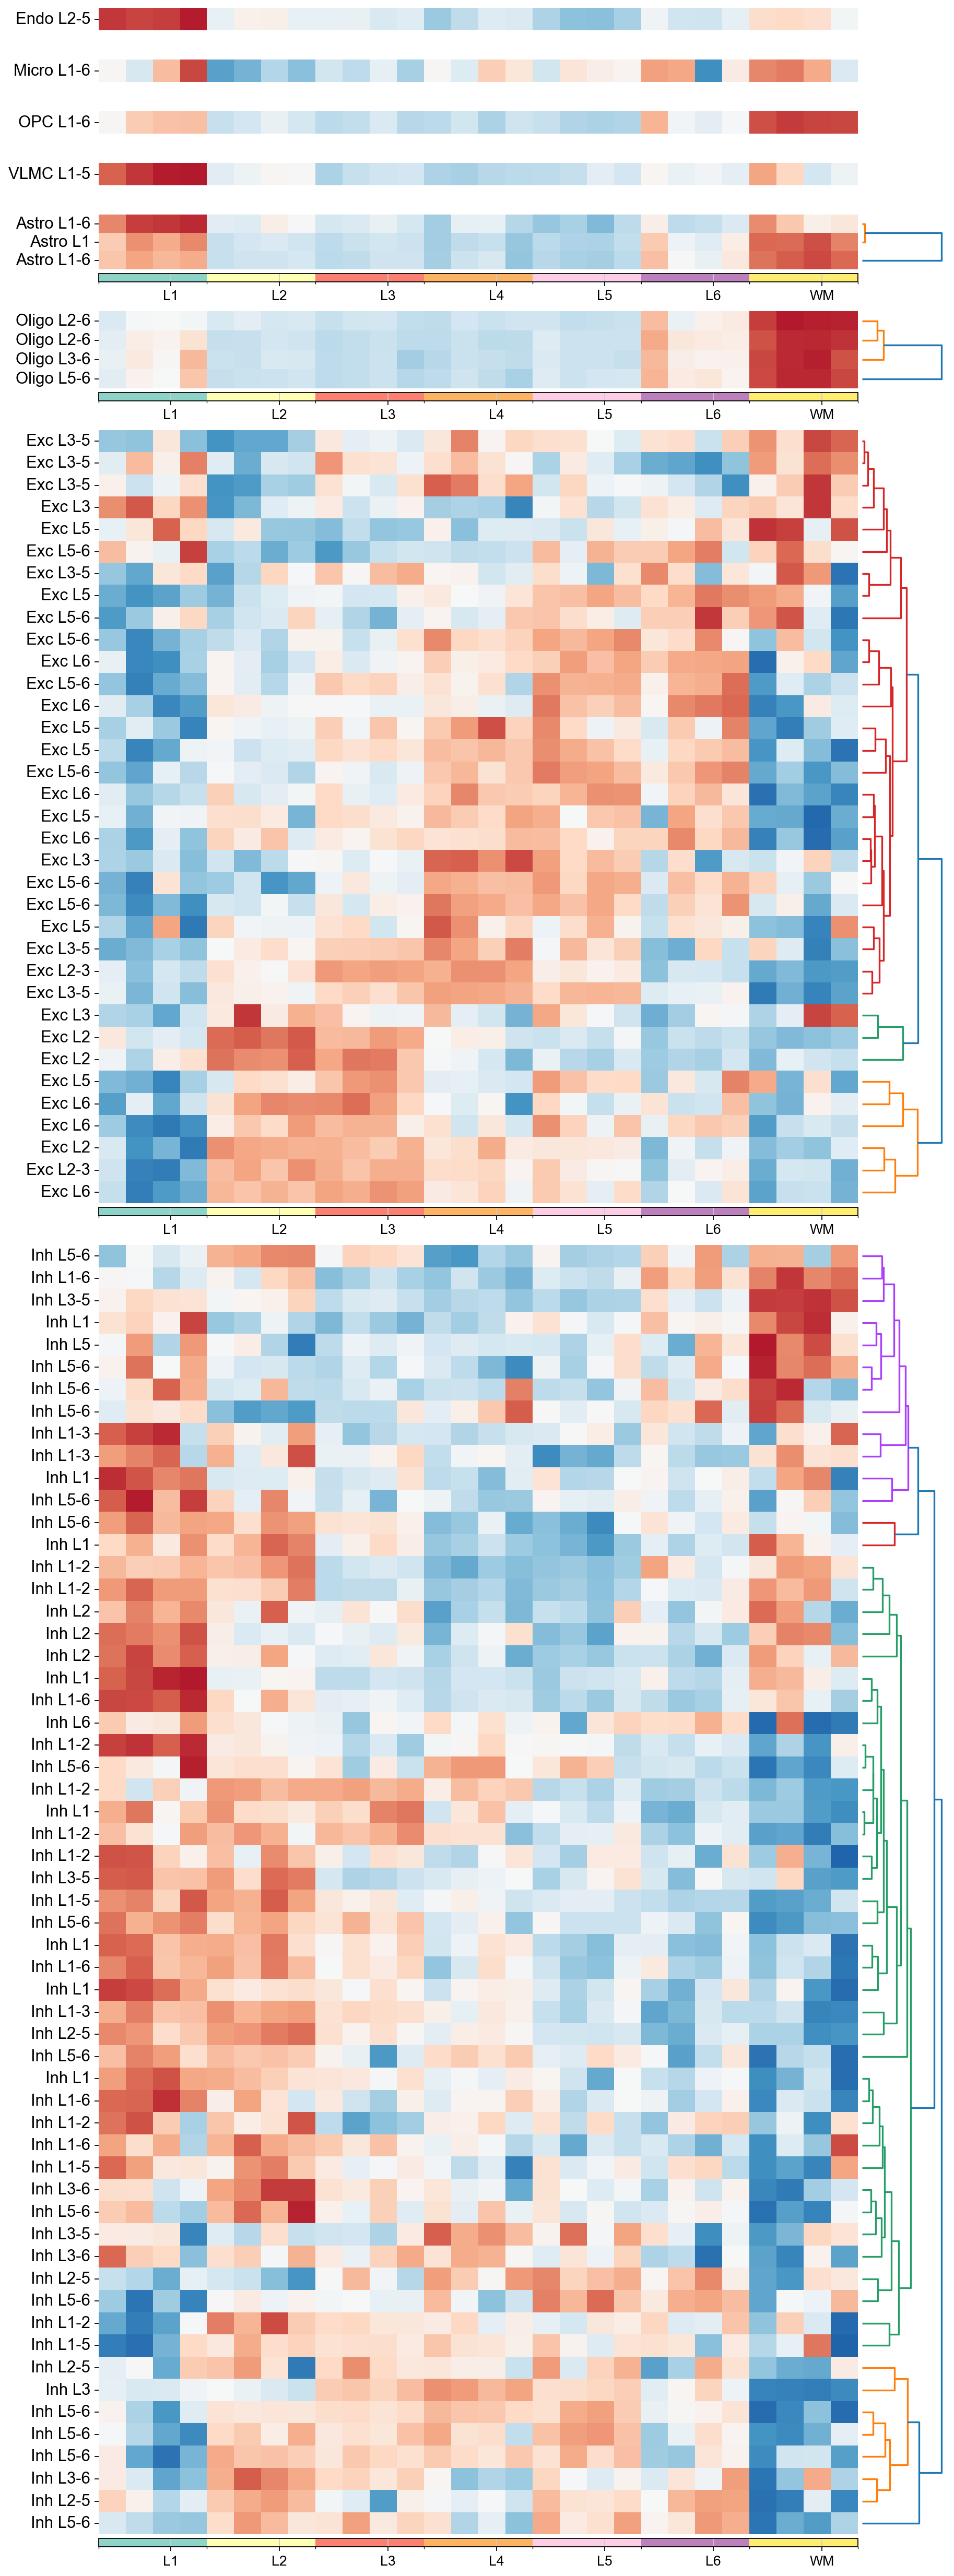

In [25]:
from scipy.cluster.hierarchy import average, leaves_list, dendrogram
from scipy.spatial.distance import pdist

cell_type_counts = pca_tr.major_ct.value_counts(ascending=True).to_dict()
fig, axes = plt.subplots(len(cell_type_counts.values()), 1, figsize=(13, 40), height_ratios=cell_type_counts.values(), gridspec_kw={'hspace': 0.1}, dpi=80)

for ct, ax in zip(cell_type_counts.keys(), axes):
    celltype_ord = nes_zscore.columns.str.contains(ct)
    samp_ord = sample_order['macaque']
    df_sub = nes_zscore.loc[samp_ord, celltype_ord].T.copy()
    df_sub.index = df_sub.index.map(lambda x: ' '.join(x.split(' ')[1:3]))
    if ct in cell_type:
        linkage = average(pdist(df_sub.values, 'cosine'))
        index_ord = leaves_list(linkage)
        sns.heatmap(df_sub.iloc[index_ord, :], ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    else:
        sns.heatmap(df_sub, ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(False)
    ax.tick_params(axis="y", which="major", rotation=0)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size=1, pad=0.05)
    cax.axis('off')

    if ct in cell_type:
        dn = dendrogram(linkage, ax=cax, orientation='right')

        # vertical
        cax = divider.append_axes('bottom', size=0.1, pad=0.05)

        cmap = plt.get_cmap('Set3')
        cond_size = adata_ssgsea[samp_ord].obs.layer.value_counts().loc[layers].values
        cond_pos = cond_size.cumsum()
        bounds = [0] + list(cond_pos)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        fig.colorbar(
            mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
            cax=cax,
            ticks=bounds,
            orientation='horizontal',
            spacing='proportional'
        )

        cax.xaxis.set_major_locator(ticker.FixedLocator(cond_pos - cond_size / 3))
        cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
        cax.set_xticklabels(cax.get_xticklabels(), rotation=0, fontsize=12)
plt.show()

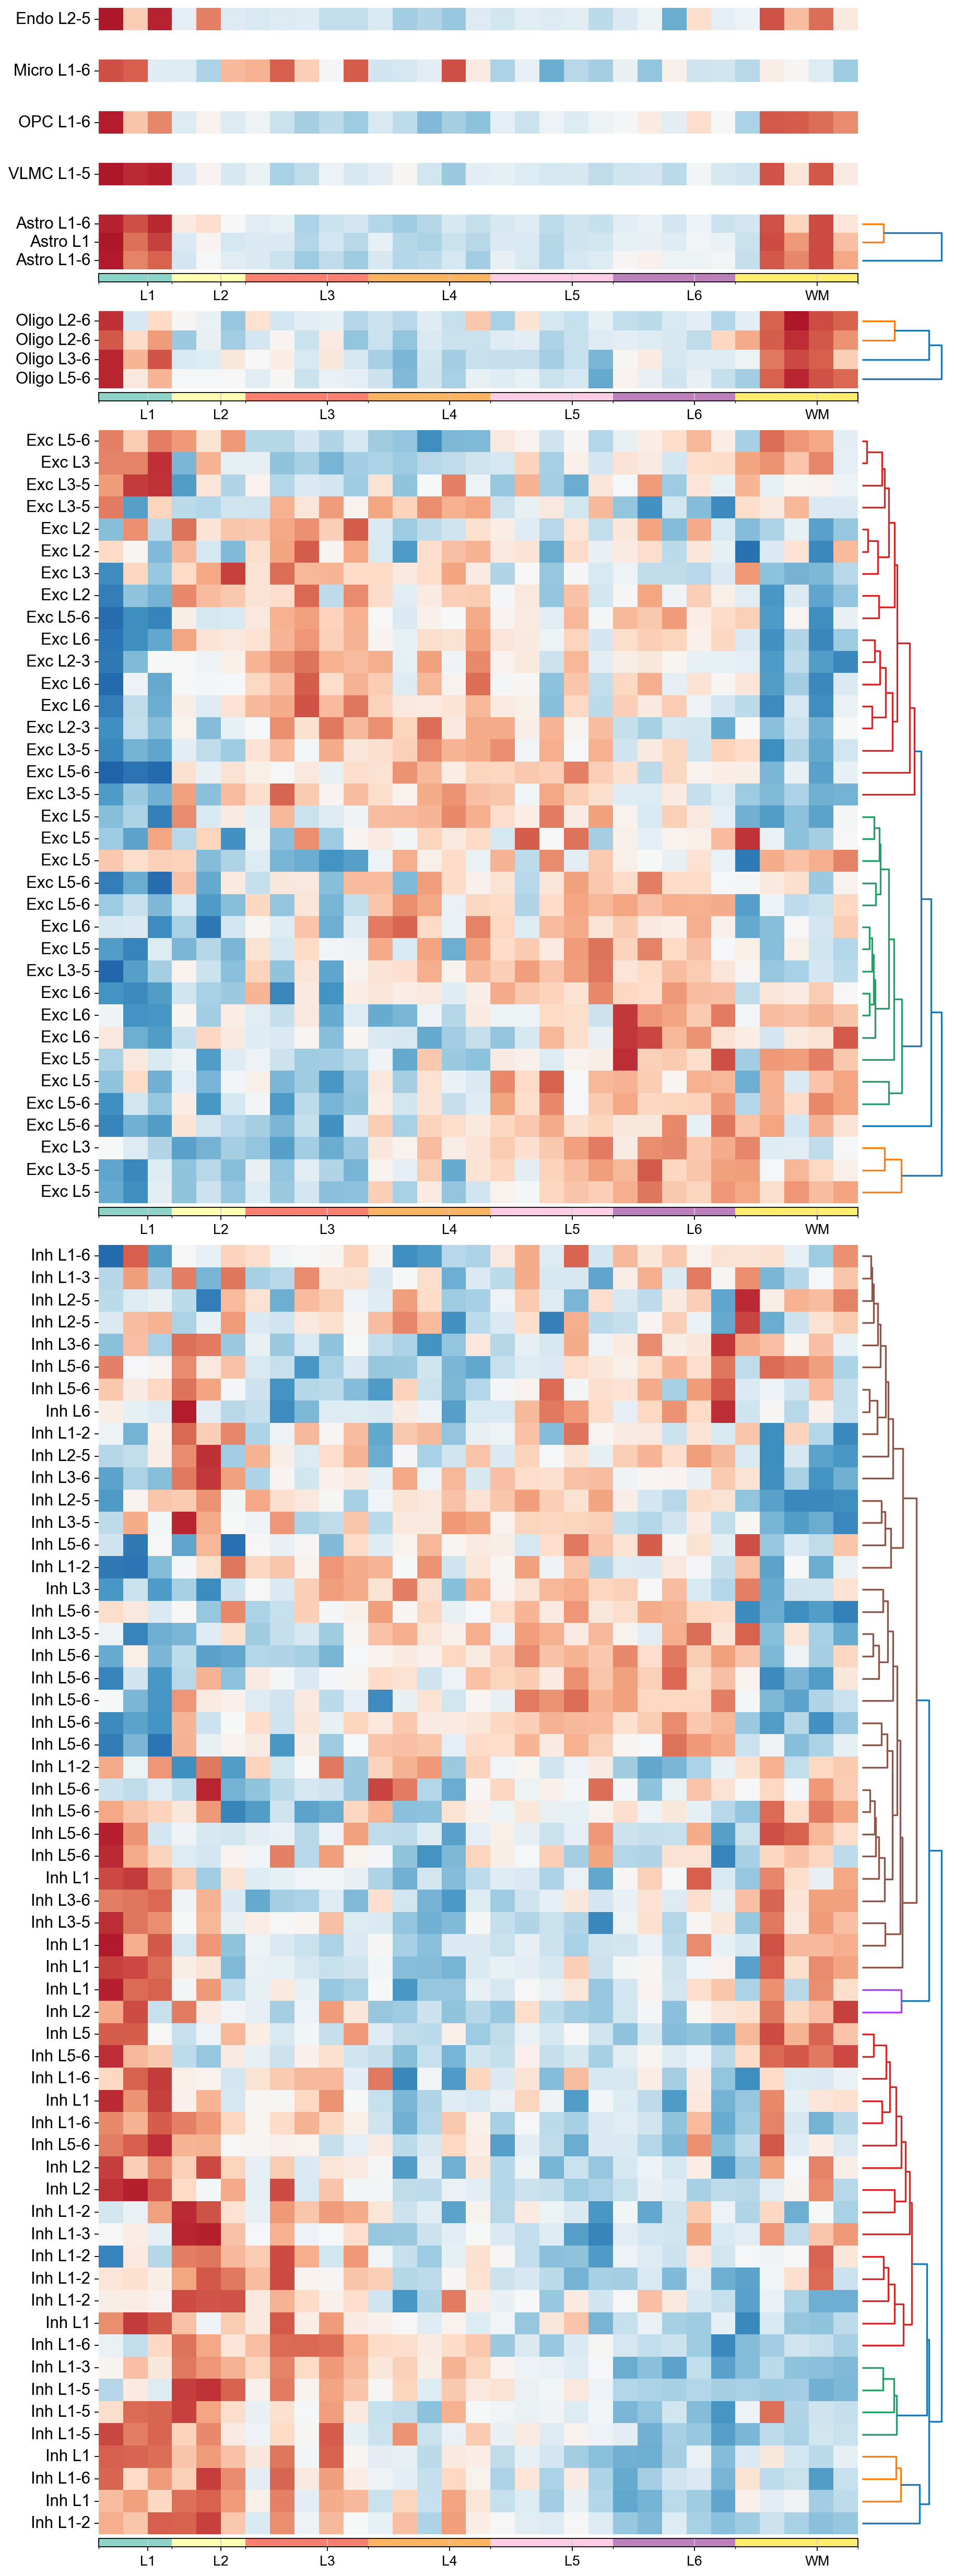

In [26]:
from scipy.cluster.hierarchy import average, leaves_list, dendrogram
from scipy.spatial.distance import pdist

cell_type_counts = pca_tr.major_ct.value_counts(ascending=True).to_dict()
fig, axes = plt.subplots(len(cell_type_counts.values()), 1, figsize=(13, 40), height_ratios=cell_type_counts.values(), gridspec_kw={'hspace': 0.1}, dpi=80)

for ct, ax in zip(cell_type_counts.keys(), axes):
    celltype_ord = nes_zscore.columns.str.contains(ct)
    samp_ord = sample_order['chimp']
    df_sub = nes_zscore.loc[samp_ord, celltype_ord].T.copy()
    df_sub.index = df_sub.index.map(lambda x: ' '.join(x.split(' ')[1:3]))
    if ct in cell_type:
        linkage = average(pdist(df_sub.values, 'cosine'))
        index_ord = leaves_list(linkage)
        sns.heatmap(df_sub.iloc[index_ord, :], ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    else:
        sns.heatmap(df_sub, ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(False)
    ax.tick_params(axis="y", which="major", rotation=0)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size=1, pad=0.05)
    cax.axis('off')

    if ct in cell_type:
        dn = dendrogram(linkage, ax=cax, orientation='right')

        # vertical
        cax = divider.append_axes('bottom', size=0.1, pad=0.05)

        cmap = plt.get_cmap('Set3')
        cond_size = adata_ssgsea[samp_ord].obs.layer.value_counts().loc[layers].values
        cond_pos = cond_size.cumsum()
        bounds = [0] + list(cond_pos)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        fig.colorbar(
            mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
            cax=cax,
            ticks=bounds,
            orientation='horizontal',
            spacing='proportional'
        )

        cax.xaxis.set_major_locator(ticker.FixedLocator(cond_pos - cond_size / 3))
        cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
        cax.set_xticklabels(cax.get_xticklabels(), rotation=0, fontsize=12)
plt.show()

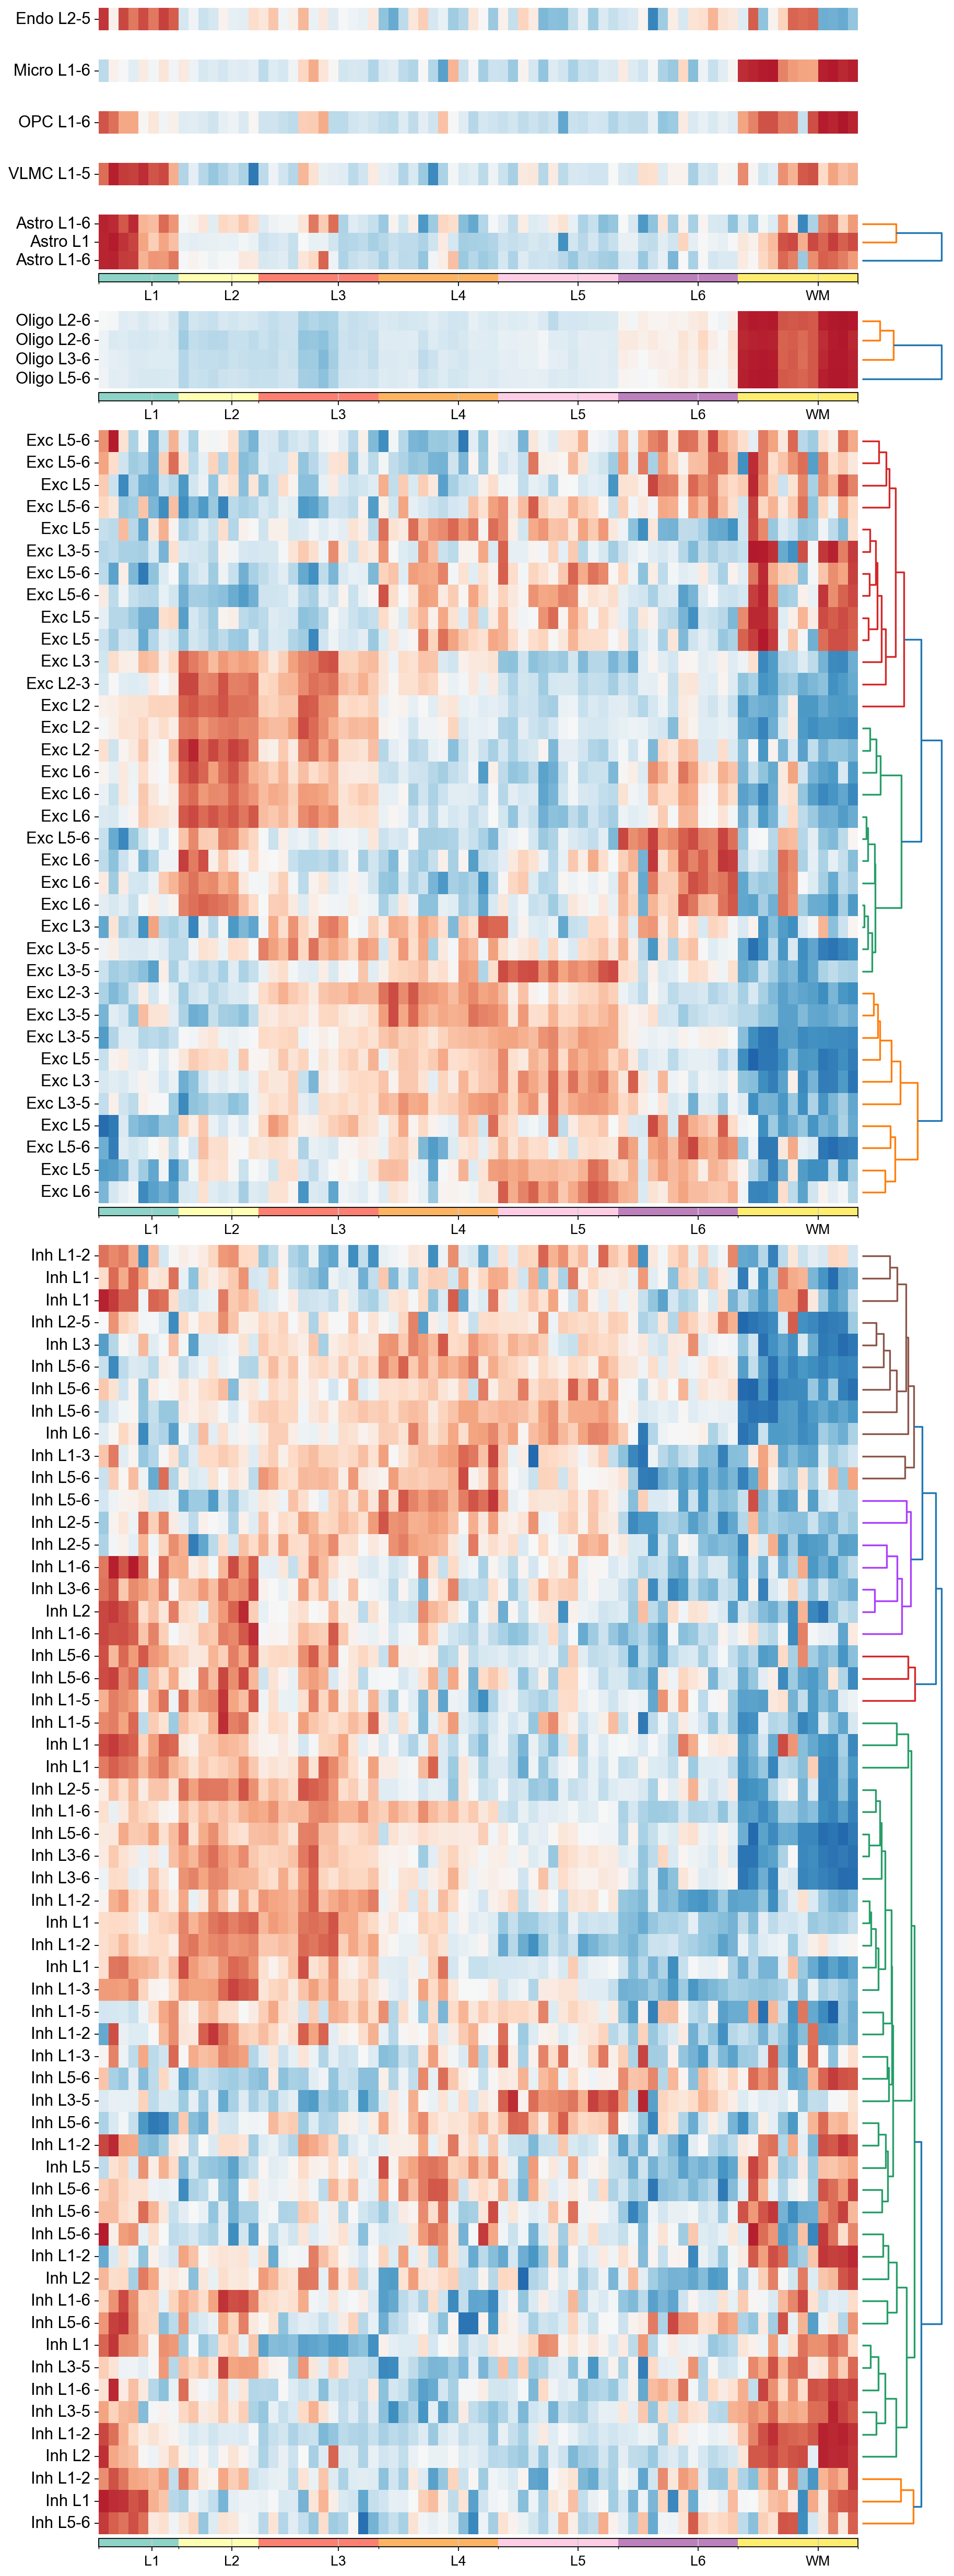

In [27]:
from scipy.cluster.hierarchy import average, leaves_list, dendrogram
from scipy.spatial.distance import pdist

cell_type_counts = pca_tr.major_ct.value_counts(ascending=True).to_dict()
fig, axes = plt.subplots(len(cell_type_counts.values()), 1, figsize=(13, 40), height_ratios=cell_type_counts.values(), gridspec_kw={'hspace': 0.1}, dpi=80)

for ct, ax in zip(cell_type_counts.keys(), axes):
    celltype_ord = nes_zscore.columns.str.contains(ct)
    samp_ord = sample_order['151']
    df_sub = nes_zscore.loc[samp_ord, celltype_ord].T.copy()
    df_sub.index = df_sub.index.map(lambda x: ' '.join(x.split(' ')[1:3]))
    if ct in cell_type:
        linkage = average(pdist(df_sub.values, 'cosine'))
        index_ord = leaves_list(linkage)
        sns.heatmap(df_sub.iloc[index_ord, :], ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    else:
        sns.heatmap(df_sub, ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(False)
    ax.tick_params(axis="y", which="major", rotation=0)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size=1, pad=0.05)
    cax.axis('off')

    if ct in cell_type:
        dn = dendrogram(linkage, ax=cax, orientation='right')

        # vertical
        cax = divider.append_axes('bottom', size=0.1, pad=0.05)

        cmap = plt.get_cmap('Set3')
        cond_size = adata_ssgsea[samp_ord].obs.layer.value_counts().loc[layers].values
        cond_pos = cond_size.cumsum()
        bounds = [0] + list(cond_pos)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        fig.colorbar(
            mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
            cax=cax,
            ticks=bounds,
            orientation='horizontal',
            spacing='proportional'
        )

        cax.xaxis.set_major_locator(ticker.FixedLocator(cond_pos - cond_size / 3))
        cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
        cax.set_xticklabels(cax.get_xticklabels(), rotation=0, fontsize=12)
plt.show()

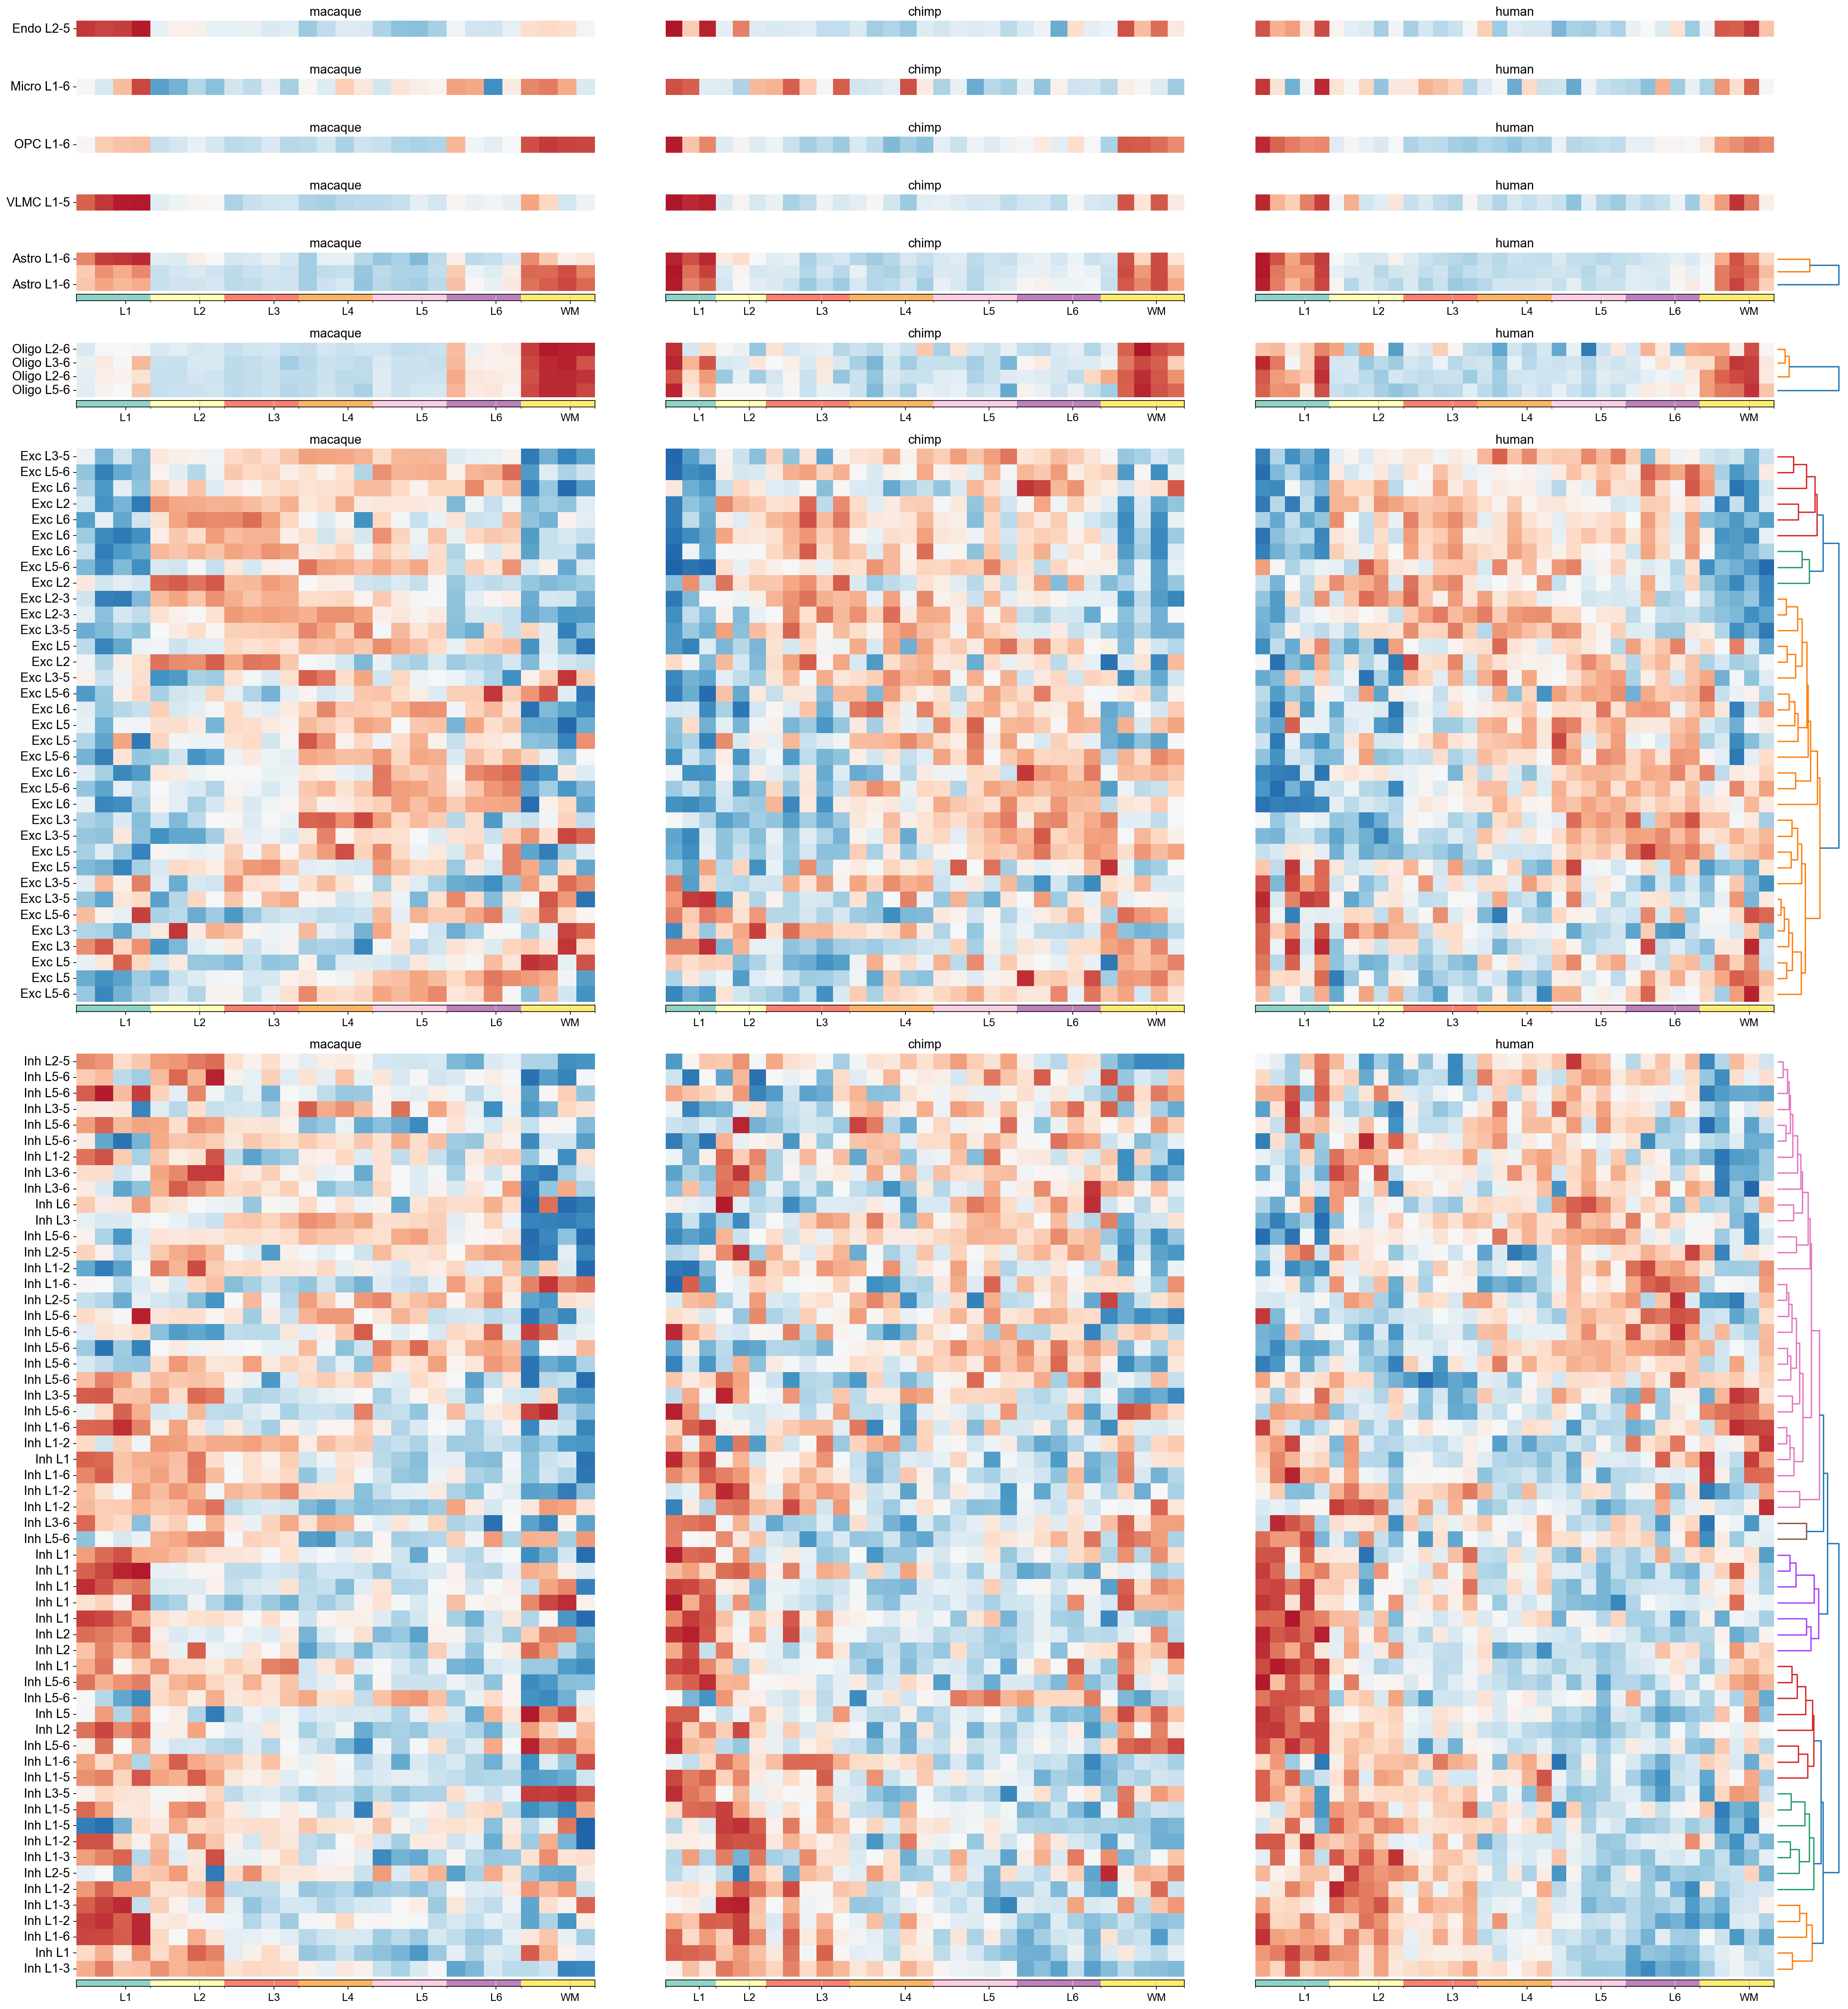

In [28]:
from scipy.cluster.hierarchy import average, leaves_list, dendrogram
from scipy.spatial.distance import pdist

cell_type_counts = pca_tr.major_ct.value_counts(ascending=True).to_dict()
fig, axes = plt.subplots(len(cell_type_counts.values()), 3, figsize=(35, 40), height_ratios=cell_type_counts.values(), gridspec_kw={'hspace': 0.2, 'wspace': 0.005}, dpi=80)


for j, ct in enumerate(cell_type_counts.keys()):
    for sp, ax in zip(['human', 'chimp', 'macaque'], axes[j, :][::-1]):
        celltype_ord = nes_zscore.columns.str.contains(ct)
        samp_ord = sample_order[sp]
        df_sub = nes_zscore.loc[samp_ord, celltype_ord].T.copy()
        df_sub.index = df_sub.index.map(lambda x: ' '.join(x.split(' ')[1:3]))
        if ct in cell_type:
            if sp == 'human':
                linkage = average(pdist(df_sub.values, 'cosine'))
                index_ord = leaves_list(linkage)
            sns.heatmap(df_sub.iloc[index_ord, :], ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
        else:
            sns.heatmap(df_sub, ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
        ax.set_title(sp)
        if sp != 'macaque':
            ax.set_yticks([])
        ax.set_xticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.grid(False)
        ax.tick_params(axis="y", which="major", rotation=0)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size=1, pad=0.05)
        cax.axis('off')

        if ct in cell_type:
            if sp == 'human':
                dn = dendrogram(linkage, ax=cax, orientation='right')

            # vertical
            cax = divider.append_axes('bottom', size=0.1, pad=0.05)

            cmap = plt.get_cmap('Set3')
            cond_size = adata_ssgsea[samp_ord].obs.layer.value_counts().loc[layers].values
            cond_pos = cond_size.cumsum()
            bounds = [0] + list(cond_pos)
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

            fig.colorbar(
                mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
                cax=cax,
                ticks=bounds,
                orientation='horizontal',
                spacing='proportional'
            )

            cax.xaxis.set_major_locator(ticker.FixedLocator(cond_pos - cond_size / 3))
            cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
            cax.set_xticklabels(cax.get_xticklabels(), rotation=0, fontsize=12)
plt.show()

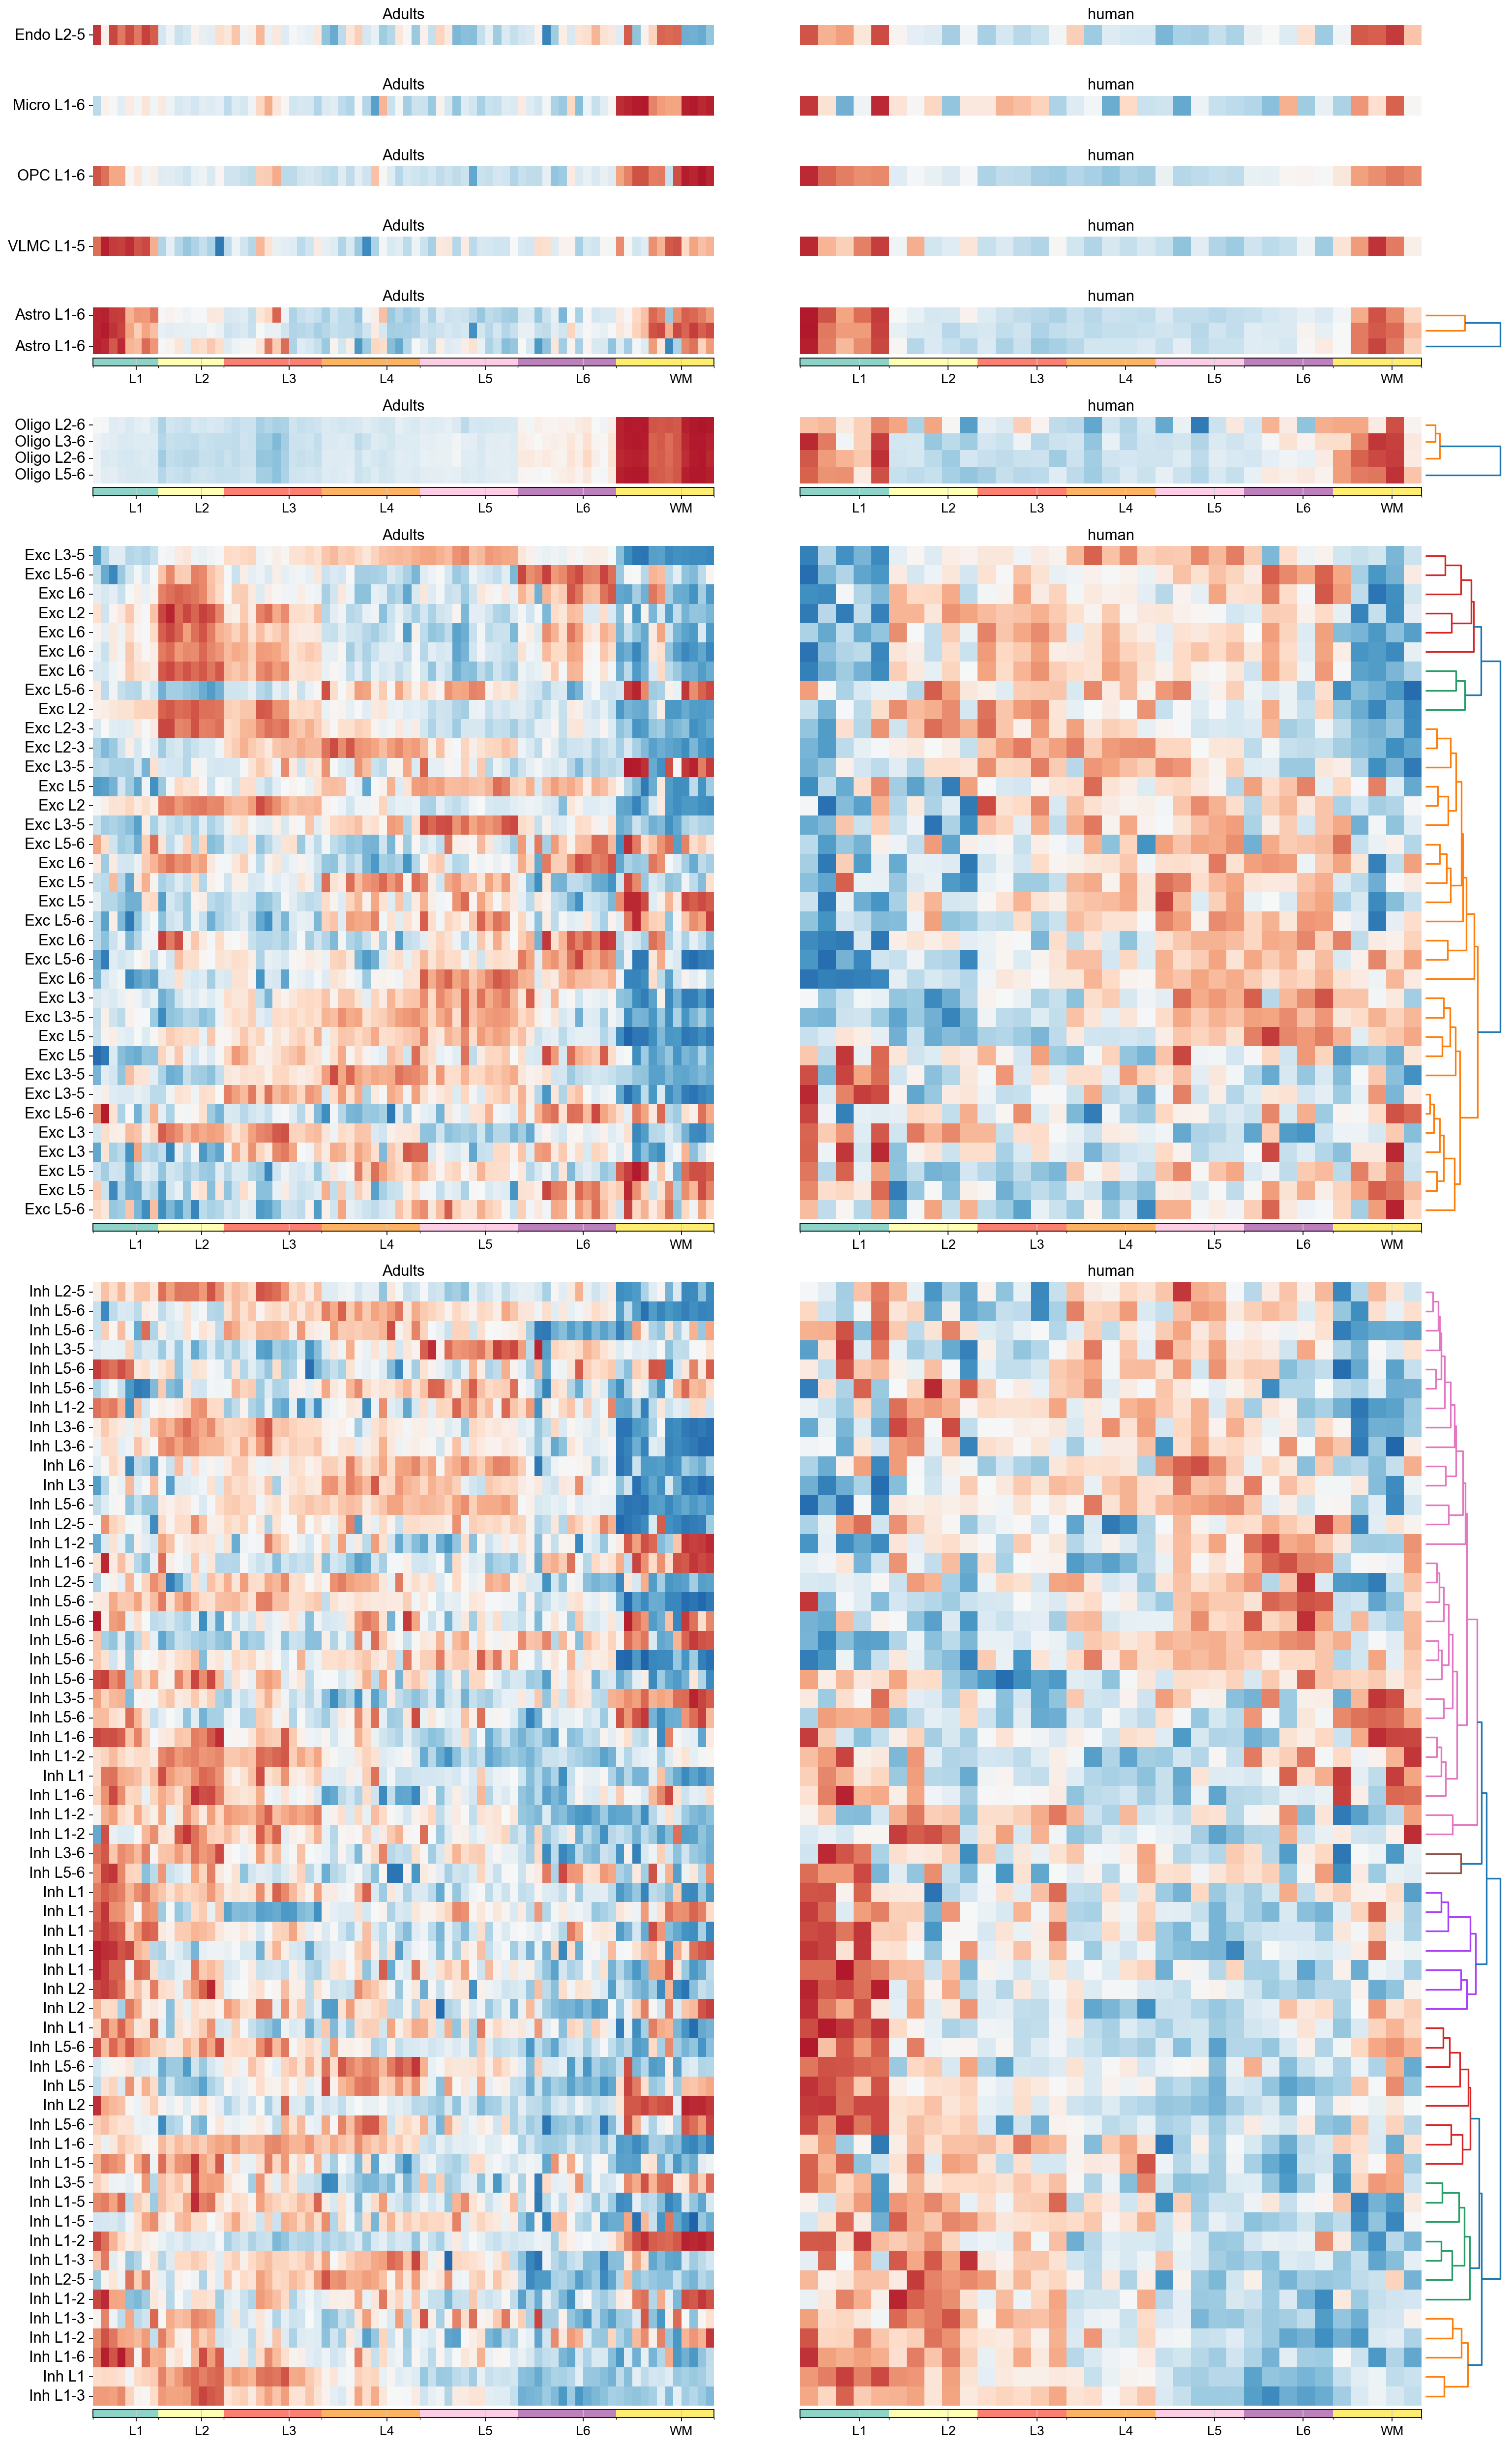

In [29]:
from scipy.cluster.hierarchy import average, leaves_list, dendrogram
from scipy.spatial.distance import pdist

cell_type_counts = pca_tr.major_ct.value_counts(ascending=True).to_dict()
fig, axes = plt.subplots(len(cell_type_counts.values()), 2, figsize=(23, 40), height_ratios=cell_type_counts.values(), gridspec_kw={'hspace': 0.2, 'wspace': 0.005}, dpi=80)


for j, ct in enumerate(cell_type_counts.keys()):
    for sp, ax in zip(['human', '151'], axes[j, :][::-1]):
        celltype_ord = nes_zscore.columns.str.contains(ct)
        samp_ord = sample_order[sp]
        df_sub = nes_zscore.loc[samp_ord, celltype_ord].T.copy()
        df_sub.index = df_sub.index.map(lambda x: ' '.join(x.split(' ')[1:3]))
        if ct in cell_type:
            if sp == 'human':
                linkage = average(pdist(df_sub.values, 'cosine'))
                index_ord = leaves_list(linkage)
            sns.heatmap(df_sub.iloc[index_ord, :], ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
        else:
            sns.heatmap(df_sub, ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
        if sp != '151':
            ax.set_yticks([])
            ax.set_title(sp)
        else:
            ax.set_title('Adults')
        ax.set_xticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.grid(False)
        ax.tick_params(axis="y", which="major", rotation=0)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size=1, pad=0.05)
        cax.axis('off')

        if ct in cell_type:
            if sp == 'human':
                dn = dendrogram(linkage, ax=cax, orientation='right')

            # vertical
            cax = divider.append_axes('bottom', size=0.1, pad=0.05)

            cmap = plt.get_cmap('Set3')
            cond_size = adata_ssgsea[samp_ord].obs.layer.value_counts().loc[layers].values
            cond_pos = cond_size.cumsum()
            bounds = [0] + list(cond_pos)
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

            fig.colorbar(
                mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
                cax=cax,
                ticks=bounds,
                orientation='horizontal',
                spacing='proportional'
            )

            cax.xaxis.set_major_locator(ticker.FixedLocator(cond_pos - cond_size / 3))
            cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
            cax.set_xticklabels(cax.get_xticklabels(), rotation=0, fontsize=12)
plt.show()

In [13]:
sc.pp.normalize_total(adata_pb, target_sum=1e6)
sc.pp.log1p(adata_pb)

normalizing counts per cell
    finished (0:00:00)


In [36]:
oligo_dict = {key:genes for key, genes in marker_genes.items() if ('Oligo' in key) and ('up' in key)}
oligo_list = [genes for genes in marker_genes.values()]
oligo_list = list(set([*oligo_list[0], *oligo_list[1], *oligo_list[2], *oligo_list[3]]))
oligo_dict.keys()

dict_keys(['Human Oligo L2-6 OPALIN FTH1P3 up', 'Human Oligo L2-6 OPALIN MAP6D1 up', 'Human Oligo L3-6 OPALIN ENPP6 up', 'Human Oligo L5-6 OPALIN LDLRAP1 up'])

In [15]:
df_expr = pd.DataFrame(adata_pb.X, columns=adata_pb.var_names, index=adata_pb.obs_names)
df_expr = df_expr[df_expr.columns.intersection(oligo_list)]
df_expr = df_expr.loc[sample_order['all']]
df_expr.head()

AAK1     ABHD2      ABI2      ABL2    ABLIM1     ACACA  \
human_759_L1  4.560373  4.877973  5.705871  3.514259  5.377689  4.654732   
human_j12_L1  4.708097  4.740596  5.640860  4.203268  5.304075  3.908381   
human_j3_L1   4.363034  5.099906  5.845626  4.490701  4.705575  3.997187   
human_j4_L1   4.310188  5.239476  5.490385  3.819850  5.144696  4.137552   
human_j6_L1   4.278244  4.816027  5.876525  4.162192  4.907685  4.221900   

                 ACACB     ACAP2     ACBD6    ACOT11  ...    ZNF451   ZNF518A  \
human_759_L1  2.241835  4.126760  4.326038  0.000000  ...  3.686351  3.632212   
human_j12_L1  1.771867  3.956215  4.001865  1.235736  ...  3.832046  3.659299   
human_j3_L1   0.000000  4.428903  5.049791  1.300802  ...  4.363034  3.108074   
human_j4_L1   0.837978  3.439418  4.378285  0.837978  ...  3.760595  3.304457   
human_j6_L1   2.186222  4.278244  4.816027  1.599541  ...  3.958140  3.701489   

                ZNF609    ZNF638    ZNF644    ZNF704    ZNF782     ZNRF3  \
human_759_L1  3.380509  4.480285  4.468302  4.803219  1.649676  4.254014   
human_j12_L1  3.956215  4.370829  4.540681  4.898061  2.750181  3.932584   
human_j3_L1   4.520224  4.941331  4.819661  5.601736  2.980907  3.648353   
human_j4_L1   3.729597  4.361691  4.158273  4.442039  2.549850  3.954235   
human_j6_L1   4.602857  4.964433  3.484498  5.876525  0.000000  3.879688   

                ZRANB2    ZSWIM5  
human_759_L1  4.503829  2.685614  
human_j12_L1  4.651469  2.580562  
human_j3_L1   5.292026  2.835178  
human_j4_L1   4.072682  2.647371  
human_j6_L1   4.679075  2.186222  

[5 rows x 1153 columns]

In [16]:
from scipy.stats import zscore
from scipy.cluster.hierarchy import average, leaves_list, dendrogram
from scipy.spatial.distance import pdist

df_expr_zscore = df_expr.copy()
df_expr_zscore['sample_id'] = adata_pb.obs.loc[df_expr_zscore.index, 'sample_id']
df_expr_zscore = df_expr_zscore.groupby('sample_id', group_keys=False).apply(zscore).dropna(axis=1)
df_expr_zscore.head()

AAK1     ABHD2      ABI2      ABL2    ABLIM1     ACACA  \
human_759_L1 -1.905516  0.657516 -2.058203 -1.363474  1.931582  0.813100   
human_j12_L1 -2.118222  1.040351 -1.677231  1.447805  1.944226 -2.246401   
human_j3_L1   0.315238  2.228204 -1.350163  1.010041 -1.741183  0.064100   
human_j4_L1  -1.825165  2.185789 -2.004646  1.080003  1.685363 -1.537915   
human_j6_L1  -2.332932  0.785095 -1.644182 -0.736584 -2.126948 -0.017137   

                 ACACB     ACAP2     ACBD6    ACOT11  ...    ZNF407    ZNF451  \
human_759_L1  1.696942  2.051243  1.286665 -0.838369  ... -2.078251 -1.501296   
human_j12_L1  0.601788  1.406840  1.511696  1.046661  ... -1.693608  0.510369   
human_j3_L1  -1.724157  1.888960  1.557653  1.161988  ...  1.432088  2.280254   
human_j4_L1  -0.605664  0.493241  1.120038  0.269052  ... -0.699317 -0.746470   
human_j6_L1   1.494217  2.239997  2.227996  0.777596  ... -1.409767  0.952230   

               ZNF518A    ZNF609    ZNF638    ZNF644    ZNF704    ZNF782  \
human_759_L1  1.979865  0.081067  1.388817  1.219156  1.082603 -0.955317   
human_j12_L1  1.917863  0.133921 -1.320189 -0.092653  1.149131  1.897032   
human_j3_L1   0.116656  1.625452  1.168976  2.035244  2.067953  2.321398   
human_j4_L1   0.325896 -0.659322  1.452292  0.514009 -0.649108  2.277074   
human_j6_L1   0.899647  1.495874  1.960929 -2.308550  2.039176 -2.335087   

                 ZNRF3    ZRANB2  
human_759_L1  2.247144 -0.165325  
human_j12_L1  2.177618  0.056255  
human_j3_L1   0.819589  2.330651  
human_j4_L1   2.221114 -1.884562  
human_j6_L1   2.308053 -1.033688  

[5 rows x 1094 columns]

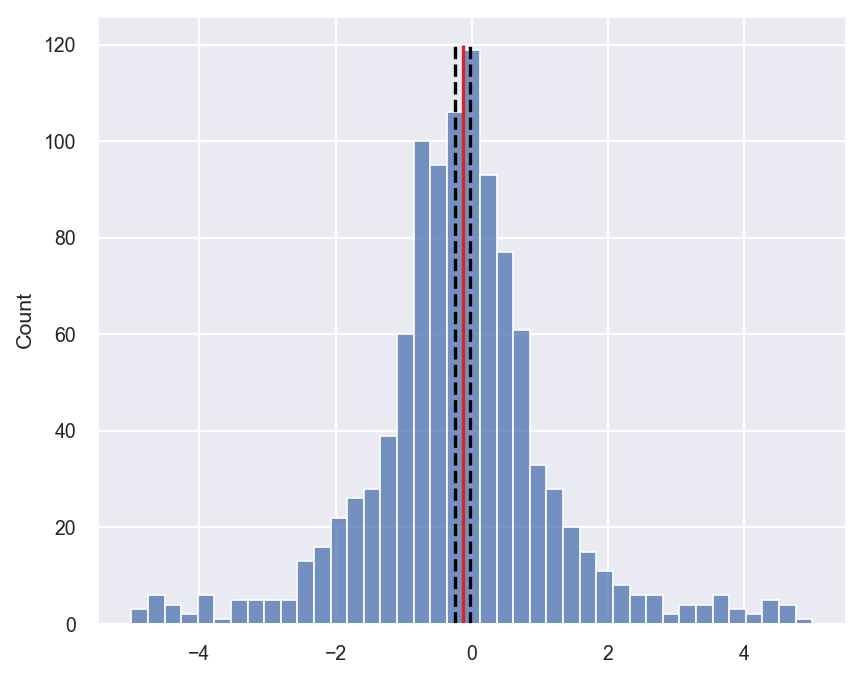

In [106]:
import scipy.stats as st

fig, ax = plt.subplots(figsize=(6, 5))

analysis_df = df_expr_zscore.copy()
analysis_df['layer'] = adata_pb.obs.loc[analysis_df.index, 'layer']
analysis_df['sample_id'] = adata_pb.obs.loc[analysis_df.index, 'sample_id']
analysis_df = analysis_df.loc[sample_order['151']].copy()
analysis_df = analysis_df[analysis_df.layer.isin(['L1', 'WM'])]
paired_samples = analysis_df['sample_id'][analysis_df['sample_id'].duplicated()].to_list()
analysis_df = analysis_df[analysis_df.sample_id.isin(paired_samples)].copy()
diff_df = analysis_df.drop('layer', axis=1).groupby('sample_id').apply(lambda x: x.iloc[1, :] - x.iloc[0, :] if x.index.any() else x.sum())
diff_df = diff_df.loc[paired_samples]
t_stat = diff_df.mean() / diff_df.std()
left_b, right_b = st.norm.interval(confidence=0.90, loc=np.mean(t_stat), scale=st.sem(t_stat))

sns.histplot(t_stat, ax=ax, binrange=[-5, 5])
ax.vlines(t_stat.mean(), 0, 120, 'tab:red')
ax.vlines(left_b, 0, 120, 'black', 'dashed')
ax.vlines(right_b, 0, 120, 'black', 'dashed')

<Axes: >

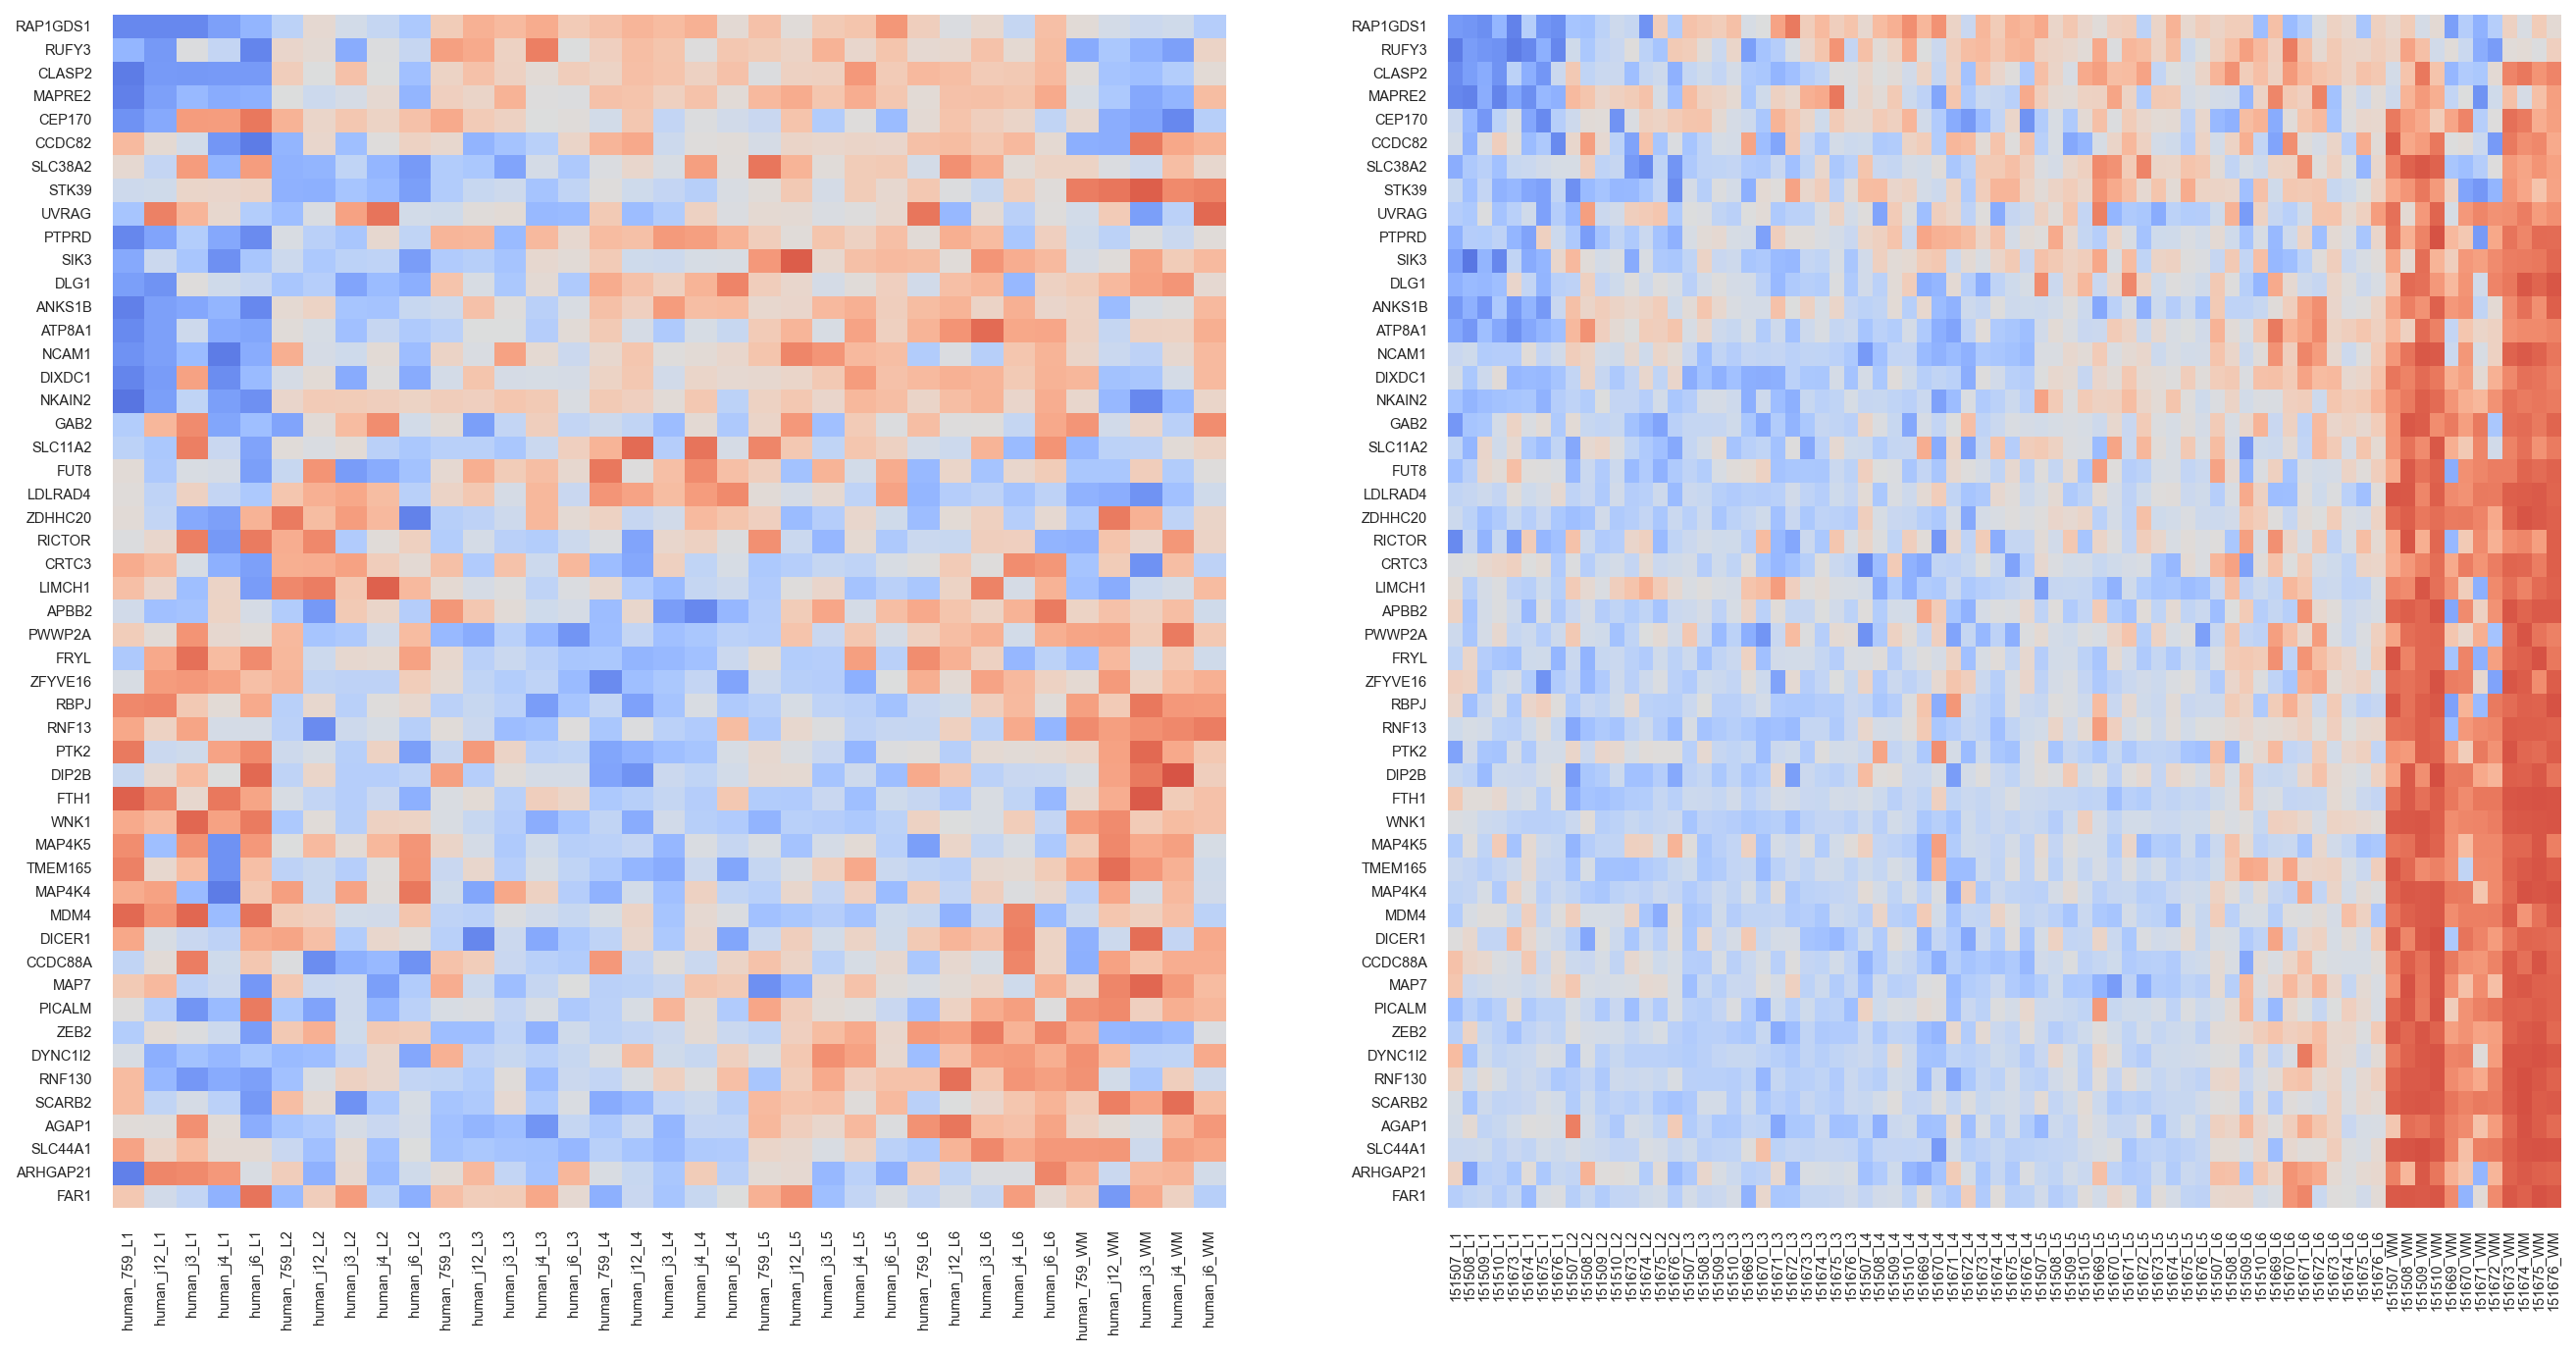

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.set(font_scale=0.6)

t_tresh = 3
samp_ord = sample_order['human'] + sample_order['151']
genes = t_stat[t_stat > t_tresh].index
df = df_expr_zscore.loc[samp_ord, genes]
linkage = average(pdist(df.T.values, 'cosine'))
ind_order = leaves_list(linkage)
gene_order = df.columns[ind_order]

samp_ord = sample_order['human']
df = df_expr_zscore.loc[samp_ord]
sns.heatmap(df[gene_order].T, cbar=False, ax=ax[0], cmap='coolwarm', center=0, vmin=-3, vmax=3)


samp_ord = sample_order['151']
df = df_expr_zscore.loc[samp_ord]
sns.heatmap(df[gene_order].T, cbar=False, ax=ax[1], cmap='coolwarm', center=0, vmin=-3, vmax=3)

In [124]:
genes

Index(['AGAP1', 'ANKS1B', 'APBB2', 'ARHGAP21', 'ATP8A1', 'CCDC82', 'CCDC88A',
       'CEP170', 'CLASP2', 'CRTC3', 'DICER1', 'DIP2B', 'DIXDC1', 'DLG1',
       'DYNC1I2', 'FAR1', 'FRYL', 'FTH1', 'FUT8', 'GAB2', 'LDLRAD4', 'LIMCH1',
       'MAP4K4', 'MAP4K5', 'MAP7', 'MAPRE2', 'MDM4', 'NCAM1', 'NKAIN2',
       'PICALM', 'PTK2', 'PTPRD', 'PWWP2A', 'RAP1GDS1', 'RBPJ', 'RICTOR',
       'RNF13', 'RNF130', 'RUFY3', 'SCARB2', 'SIK3', 'SLC11A2', 'SLC38A2',
       'SLC44A1', 'STK39', 'TMEM165', 'UVRAG', 'WNK1', 'ZDHHC20', 'ZEB2',
       'ZFYVE16'],
      dtype='object')

In [ ]:
sns.set(font_scale=1)

# Enrichment analysis (Azimuth)

## Preprocess data

## ssGSEA

In [29]:
ss = gseapy.ssgsea(
    data=df_ssgsea.T,
    gene_sets='Azimuth_2023',
    outdir=None,
    min_size=3,
    sample_norm_method="rank",
    no_plot=True
)
ssGSEA_res = ss.res2d
ssGSEA_res.head()

Name                                        Term           ES  \
0   chimp_11454_L1                         PBMC-L1-CD4+ T Cell  3781.915877   
1   chimp_11454_L1             Motor Cortex-subclass-Astrocyte  3781.211165   
2  macaque_0701_WM  Fetal Development-L2-Adrenal-Schwann Cells  3778.977777   
3   chimp_11454_L5                         PBMC-L1-CD4+ T Cell  3778.530608   
4        151669_L3                         PBMC-L1-CD4+ T Cell  3777.869708   

        NES  
0  0.504146  
1  0.504052  
2  0.503755  
3  0.503695  
4  0.503607

We will work with normalized score from now on

In [30]:
nes.index.to_list()

['Human Astro L1 FGFR3 SERPINI2 up',
 'Human Astro L1-6 FGFR3 AQP1 up',
 'Human Astro L1-6 FGFR3 PLCG1 up',
 'Human Endo L2-5 NOSTRIN SRGN up',
 'Human Exc L2 LAMP5 KCNG3 up',
 'Human Exc L2 LINC00507 ATP7B up',
 'Human Exc L2 LINC00507 GLRA3 up',
 'Human Exc L2-3 LINC00507 DSG3 up',
 'Human Exc L2-3 RORB CCDC68 up',
 'Human Exc L3 LAMP5 CARM1P1 up',
 'Human Exc L3 RORB OTOGL up',
 'Human Exc L3 THEMIS ENPEP up',
 'Human Exc L3-5 FEZF2 ASGR2 up',
 'Human Exc L3-5 RORB LAMA4 up',
 'Human Exc L3-5 RORB LINC01202 up',
 'Human Exc L3-5 RORB LNX2 up',
 'Human Exc L3-5 RORB RPRM up',
 'Human Exc L3-5 RORB TNNT2 up',
 'Human Exc L5 FEZF2 NREP-AS1 up',
 'Human Exc L5 FEZF2 PKD2L1 up',
 'Human Exc L5 FEZF2 RNF144A-AS1 up',
 'Human Exc L5 RORB MED8 up',
 'Human Exc L5 THEMIS FGF10 up',
 'Human Exc L5 THEMIS RGPD6 up',
 'Human Exc L5 THEMIS VILL up',
 'Human Exc L5-6 FEZF2 C9orf135-AS1 up',
 'Human Exc L5-6 FEZF2 CFTR up',
 'Human Exc L5-6 FEZF2 FILIP1L up',
 'Human Exc L5-6 FEZF2 IFNG-AS1 up',
 

In [31]:
nes = ssGSEA_res.pivot(index='Term', columns='Name', values='NES').astype(float)
nes = nes.loc[(nes.index.str.contains('Cortex')) & (~nes.index.str.contains('Mouse')) & (nes.index.str.contains('Cortex-cluster')), sample_order['all']]
nes.head(2)

Name                                                human_759_L1  \
Term                                                               
Motor Cortex-cluster-FEZF2+ ASGR2+ Layer 3-5 Gl...     -0.140756   
Motor Cortex-cluster-FEZF2+ C9orf135-AS1+ Layer...      0.089328   

Name                                                human_j12_L1  human_j3_L1  \
Term                                                                            
Motor Cortex-cluster-FEZF2+ ASGR2+ Layer 3-5 Gl...     -0.074547    -0.180286   
Motor Cortex-cluster-FEZF2+ C9orf135-AS1+ Layer...      0.058898    -0.187592   

Name                                                human_j4_L1  human_j6_L1  \
Term                                                                           
Motor Cortex-cluster-FEZF2+ ASGR2+ Layer 3-5 Gl...    -0.217153    -0.145056   
Motor Cortex-cluster-FEZF2+ C9orf135-AS1+ Layer...     0.009565    -0.035707   

Name                                                human_759_L2  \
Term                                                               
Motor Cortex-cluster-FEZF2+ ASGR2+ Layer 3-5 Gl...     -0.236519   
Motor Cortex-cluster-FEZF2+ C9orf135-AS1+ Layer...      0.042463   

Name                                                human_j12_L2  human_j3_L2  \
Term                                                                            
Motor Cortex-cluster-FEZF2+ ASGR2+ Layer 3-5 Gl...     -0.080598    -0.257635   
Motor Cortex-cluster-FEZF2+ C9orf135-AS1+ Layer...      0.088687    -0.266949   

Name                                                human_j4_L2  human_j6_L2  \
Term                                                                           
Motor Cortex-cluster-FEZF2+ ASGR2+ Layer 3-5 Gl...    -0.219699    -0.146716   
Motor Cortex-cluster-FEZF2+ C9orf135-AS1+ Layer...    -0.020830    -0.121174   

Name                                                ...  151509_WM  151510_WM  \
Term                                                ...                         
Motor Cortex-cluster-FEZF2+ ASGR2+ Layer 3-5 Gl...  ...  -0.145738  -0.185881   
Motor Cortex-cluster-FEZF2+ C9orf135-AS1+ Layer...  ...  -0.123360  -0.094589   

Name                                                151669_WM  151670_WM  \
Term                                                                       
Motor Cortex-cluster-FEZF2+ ASGR2+ Layer 3-5 Gl...  -0.159180  -0.165877   
Motor Cortex-cluster-FEZF2+ C9orf135-AS1+ Layer...   0.028851   0.059918   

Name                                                151671_WM  151672_WM  \
Term                                                                       
Motor Cortex-cluster-FEZF2+ ASGR2+ Layer 3-5 Gl...  -0.211991  -0.175892   
Motor Cortex-cluster-FEZF2+ C9orf135-AS1+ Layer...  -0.025727  -0.026941   

Name                                                151673_WM  151674_WM  \
Term                                                                       
Motor Cortex-cluster-FEZF2+ ASGR2+ Layer 3-5 Gl...  -0.185209  -0.208304   
Motor Cortex-cluster-FEZF2+ C9orf135-AS1+ Layer...  -0.114263  -0.103572   

Name                                                151675_WM  151676_WM  
Term                                                                      
Motor Cortex-cluster-FEZF2+ ASGR2+ Layer 3-5 Gl...  -0.165678  -0.147650  
Motor Cortex-cluster-FEZF2+ C9orf135-AS1+ Layer...  -0.060310  -0.047055  

[2 rows x 170 columns]

In [32]:
adata_ssgsea = an.AnnData(nes.T, obs=adata_pb.obs.loc[sample_order['all']])
adata_ssgsea

AnnData object with n_obs × n_vars = 170 × 96
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'

In [33]:
sc.pp.pca(adata_ssgsea)

computing PCA
    with n_comps=50
    finished (0:00:00)


computing PCA
    with n_comps=34
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


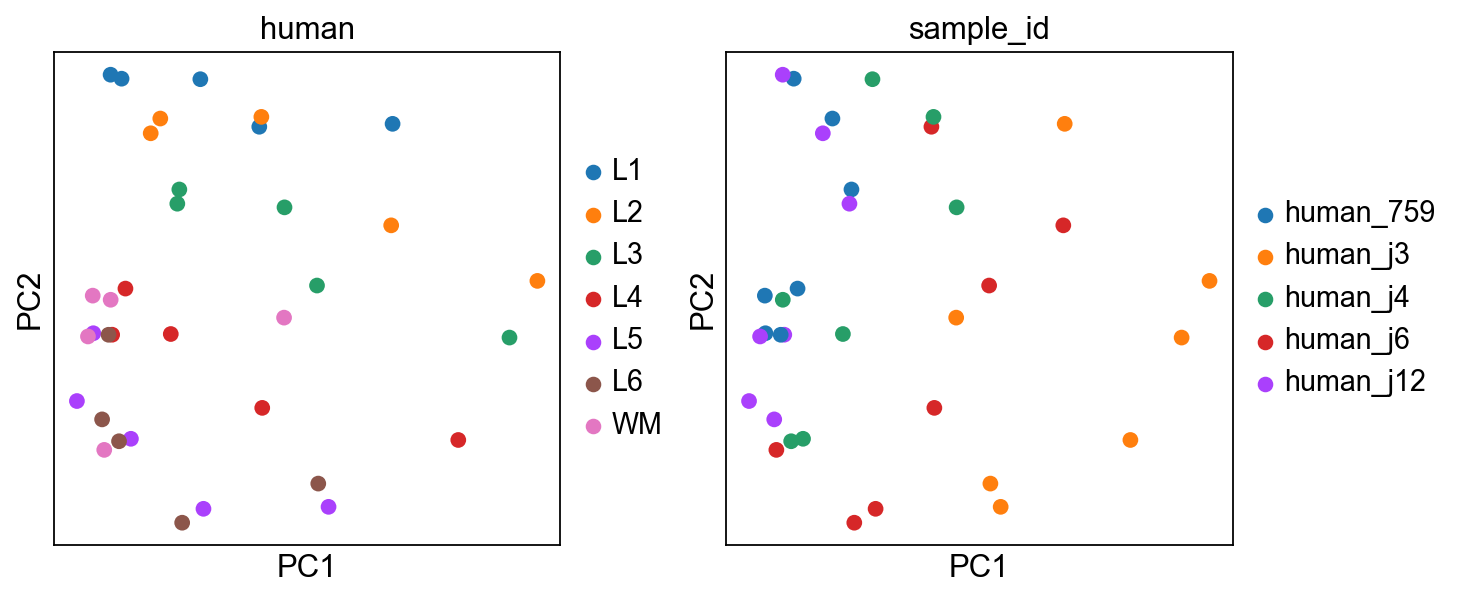

computing PCA
    with n_comps=30
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


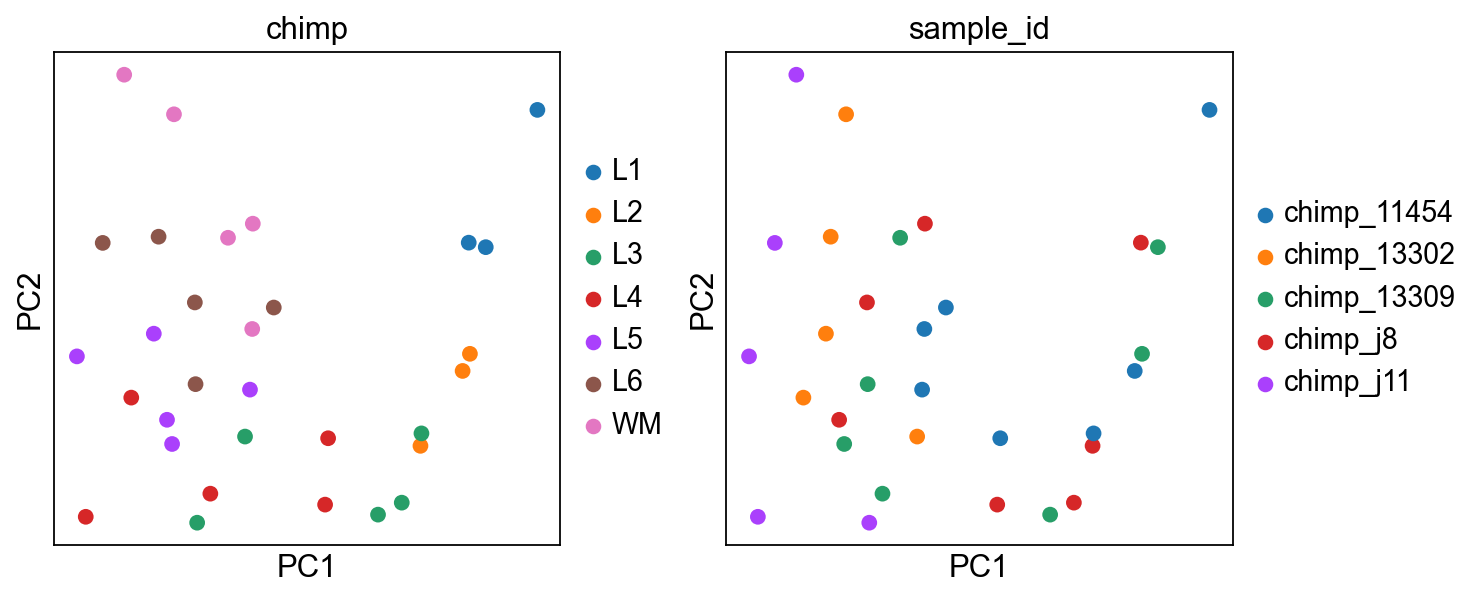

computing PCA
    with n_comps=27
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


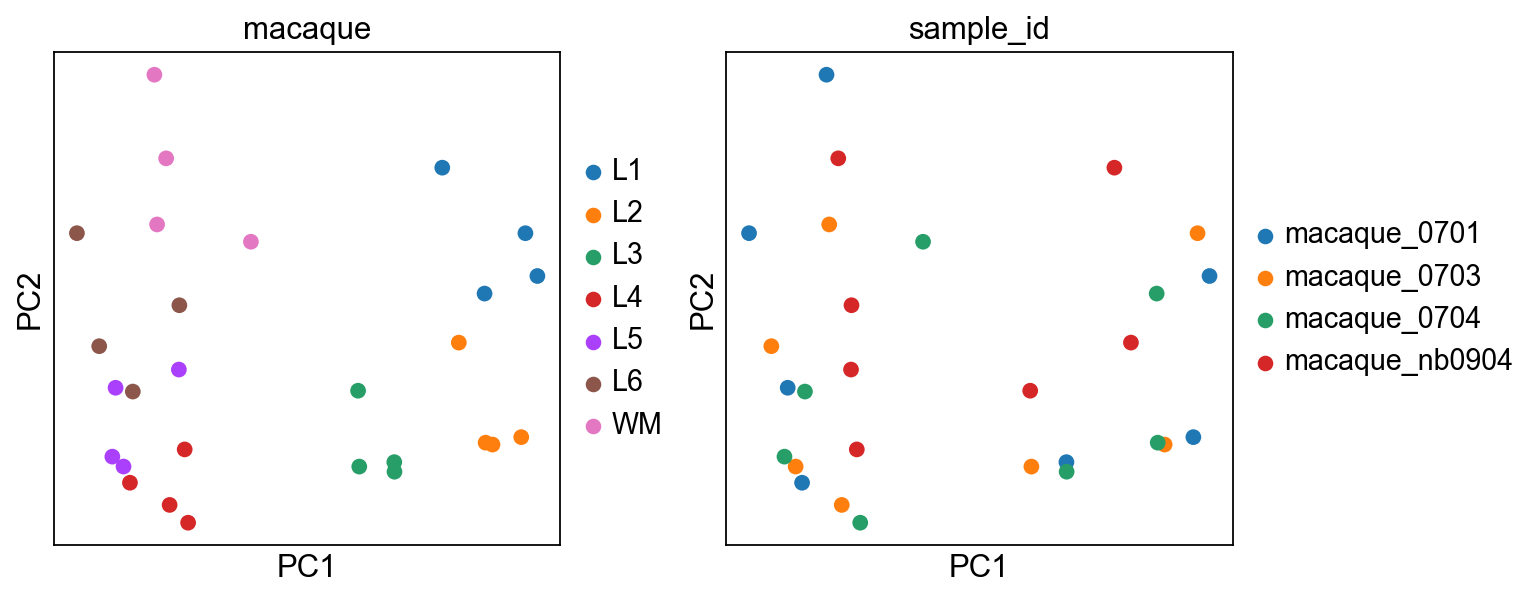

computing PCA
    with n_comps=50
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


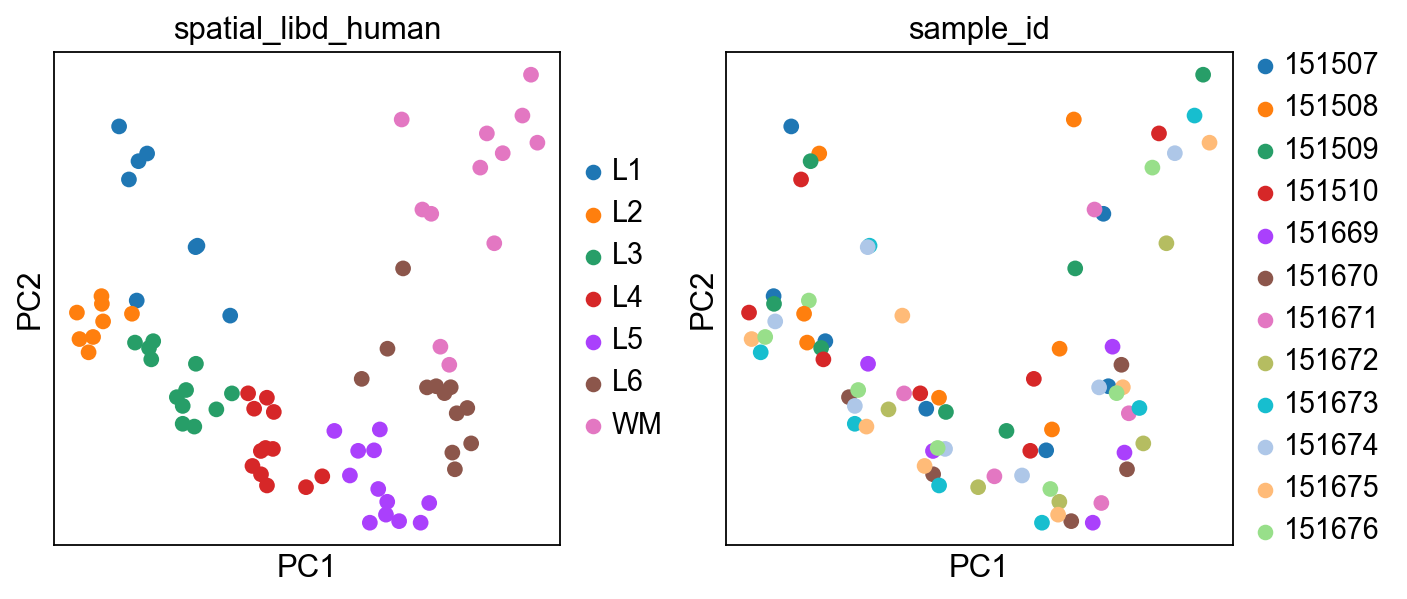

In [34]:
for cond in ['human', 'chimp', 'macaque', 'spatial_libd_human']:
    adata_cond = adata_ssgsea[adata_ssgsea.obs.condition == cond, :].copy()
    sc.pp.pca(adata_cond, return_info=False)
    sc.pl.pca(adata_cond, color=['layer', 'sample_id'], size=200, ncols=2, title=cond)

d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


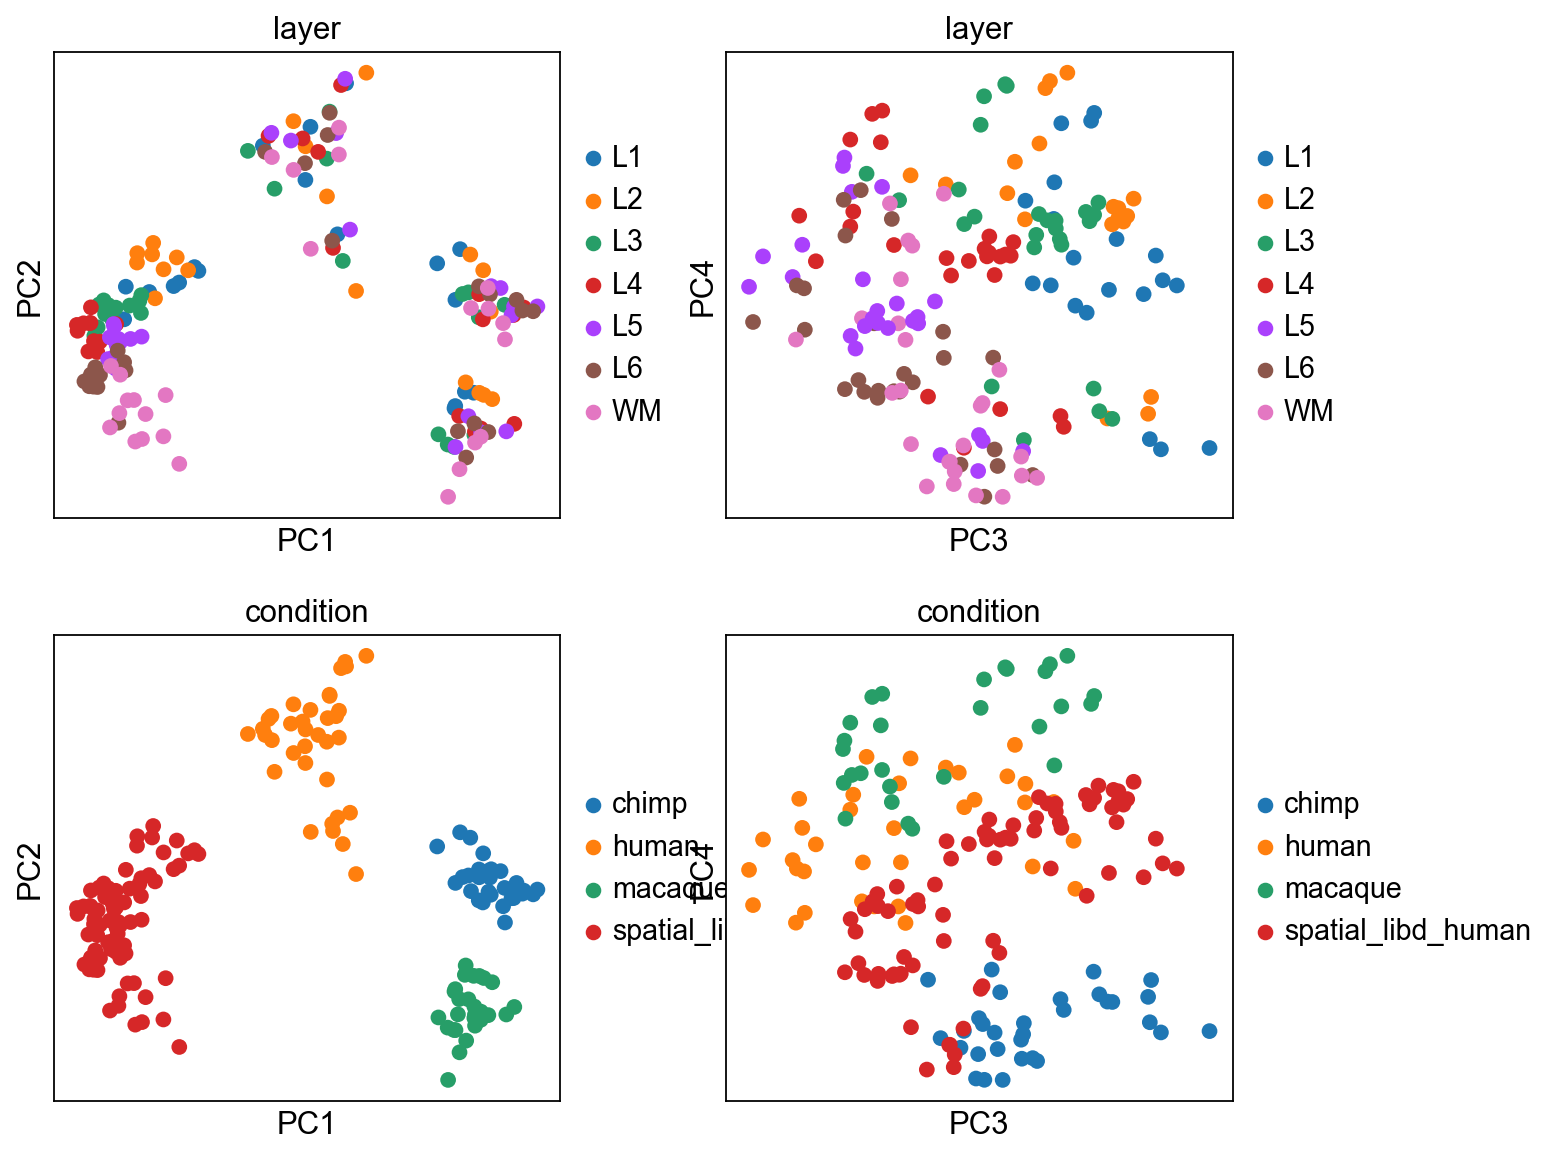

In [35]:
sc.pl.pca(adata_ssgsea, color=['layer', 'condition'], size=200, ncols=2, components = ['1,2','3,4'])

In [36]:
from scipy.stats import zscore
nes_zscore = nes.T
nes_zscore['sample_id'] = adata_ssgsea.obs.sample_id
nes_zscore = nes_zscore.groupby('sample_id', group_keys=False).apply(zscore)
nes_zscore.head()

Term          Motor Cortex-cluster-FEZF2+ ASGR2+ Layer 3-5 Glutamatergic Neuron  \
Name                                                                              
human_759_L1                                          -0.356200                   
human_j12_L1                                          -0.865562                   
human_j3_L1                                           -0.639207                   
human_j4_L1                                           -1.192790                   
human_j6_L1                                           -1.198547                   

Term          Motor Cortex-cluster-FEZF2+ C9orf135-AS1+ Layer 5-6 Glutamatergic Neuron  \
Name                                                                                     
human_759_L1                                          -0.626500                          
human_j12_L1                                          -1.219320                          
human_j3_L1                                           -1.048810                          
human_j4_L1                                           -1.044991                          
human_j6_L1                                           -0.835068                          

Term          Motor Cortex-cluster-FEZF2+ CSN1S1+ Layer 5 Glutamatergic Neuron  \
Name                                                                             
human_759_L1                                          -1.561799                  
human_j12_L1                                          -0.953291                  
human_j3_L1                                           -0.331864                  
human_j4_L1                                           -1.148625                  
human_j6_L1                                           -0.845871                  

Term          Motor Cortex-cluster-FEZF2+ FILIP1L+ Layer 5-6 Glutamatergic Neuron  \
Name                                                                                
human_759_L1                                           0.233668                     
human_j12_L1                                          -0.932620                     
human_j3_L1                                           -0.378698                     
human_j4_L1                                           -0.419082                     
human_j6_L1                                           -0.118502                     

Term          Motor Cortex-cluster-FEZF2+ IFNG-AS1+ Layer 5-6 Glutamatergic Neuron  \
Name                                                                                 
human_759_L1                                          -1.524069                      
human_j12_L1                                          -1.505902                      
human_j3_L1                                           -0.085682                      
human_j4_L1                                           -1.152347                      
human_j6_L1                                           -0.668268                      

Term          Motor Cortex-cluster-FEZF2+ KLK7+ Layer 6 Glutamatergic Neuron  \
Name                                                                           
human_759_L1                                          -1.672239                
human_j12_L1                                          -1.176573                
human_j3_L1                                           -1.862104                
human_j4_L1                                           -1.660111                
human_j6_L1                                           -2.032403                

Term          Motor Cortex-cluster-FEZF2+ NREP-AS1+ Layer 5 Glutamatergic Neuron  \
Name                                                                               
human_759_L1                                          -1.543256                    
human_j12_L1                                          -1.017851                    
human_j3_L1                                           -1.077988                    
human_j4_L1                     

In [37]:
from sklearn.decomposition import PCA
X = nes_zscore.T.values
pca = PCA(n_components=2)
X_transf = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.27250484 0.16718168]
[63.83443245 49.99910558]


In [38]:
name_map = {
    "GABAergic Neuron": 'GABA',
    "Glutamatergic Neuron": "Glut",
    "Oligodendrocyte": "Oligo",
    "Astrocyte": "Astro",
    "Oligodendrocyte Precursor Cell": "OPC",
    "Vascular Lepotomeningeal Cell": "VLC",
    "Microglia": "Mic"
}

cellt = [name.split() for name in nes_zscore.columns]
ct_name = [name_map[' '.join(name[name.index('Layer') + 2:])] for name in cellt]
layer_name = [f'L{name[name.index("Layer") + 1]}' for name in cellt]
nes_zscore.columns = list(map(lambda x: " ".join(x), zip(layer_name, ct_name)))

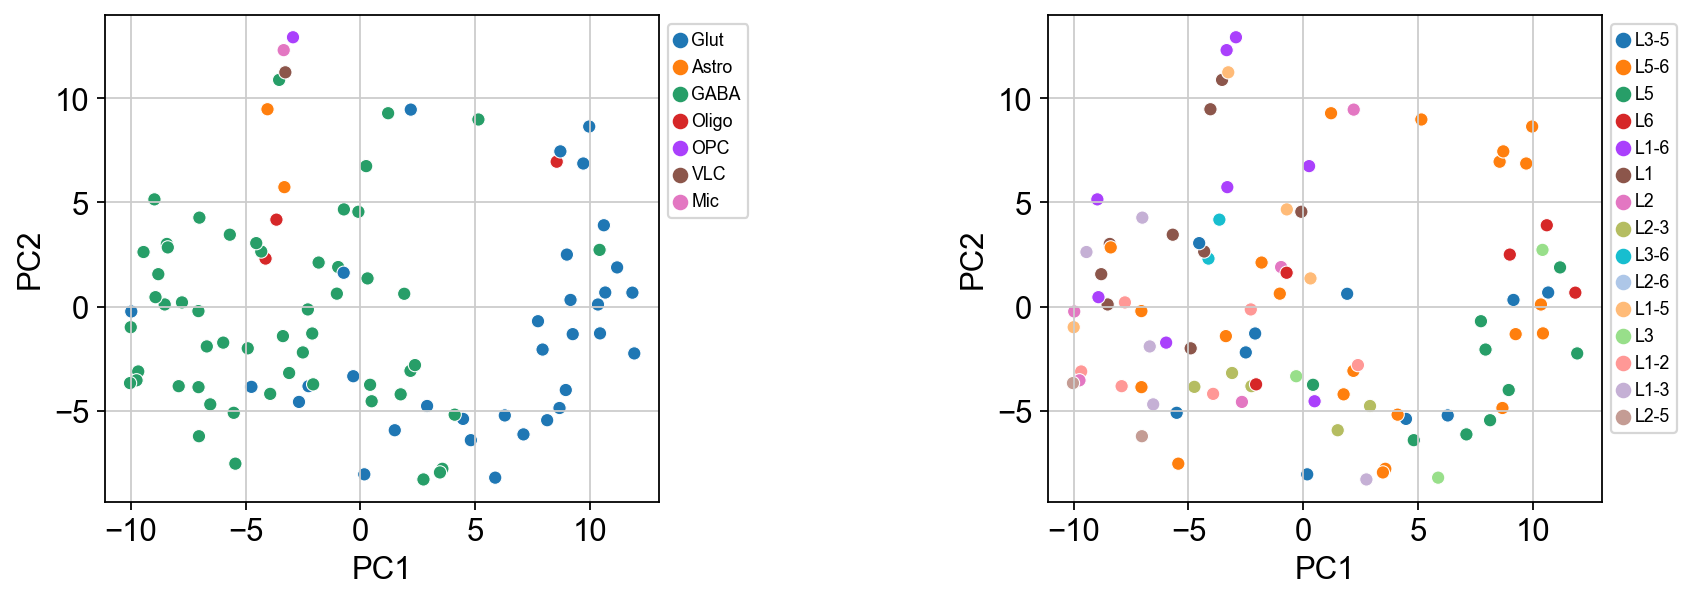

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'wspace': 0.7}, dpi=80)
pca_tr = pd.DataFrame(X_transf, index=nes_zscore.columns, columns=['PC1', 'PC2'])
cellt = [name.split() for name in pca_tr.index]
pca_tr['major_ct'] = [name[1] for name in cellt]
pca_tr['layer'] = [name[0] for name in cellt]
sns.scatterplot(pca_tr, x='PC1', y='PC2', hue='major_ct', ax=ax[0])
ax[0].legend(fontsize=2, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":8})
sns.scatterplot(pca_tr, x='PC1', y='PC2', hue='layer', ax=ax[1])
ax[1].legend(fontsize=2, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":8})

In [40]:
pca_tr['major_ct'].value_counts()

major_ct
GABA     54
Glut     33
Oligo     4
Astro     2
OPC       1
VLC       1
Mic       1
Name: count, dtype: int64

In [41]:
cell_type = ['Oligo', 'Glut', 'GABA']
unique_celltypes = ['VLC', 'Mic', 'OPC', 'Astro']

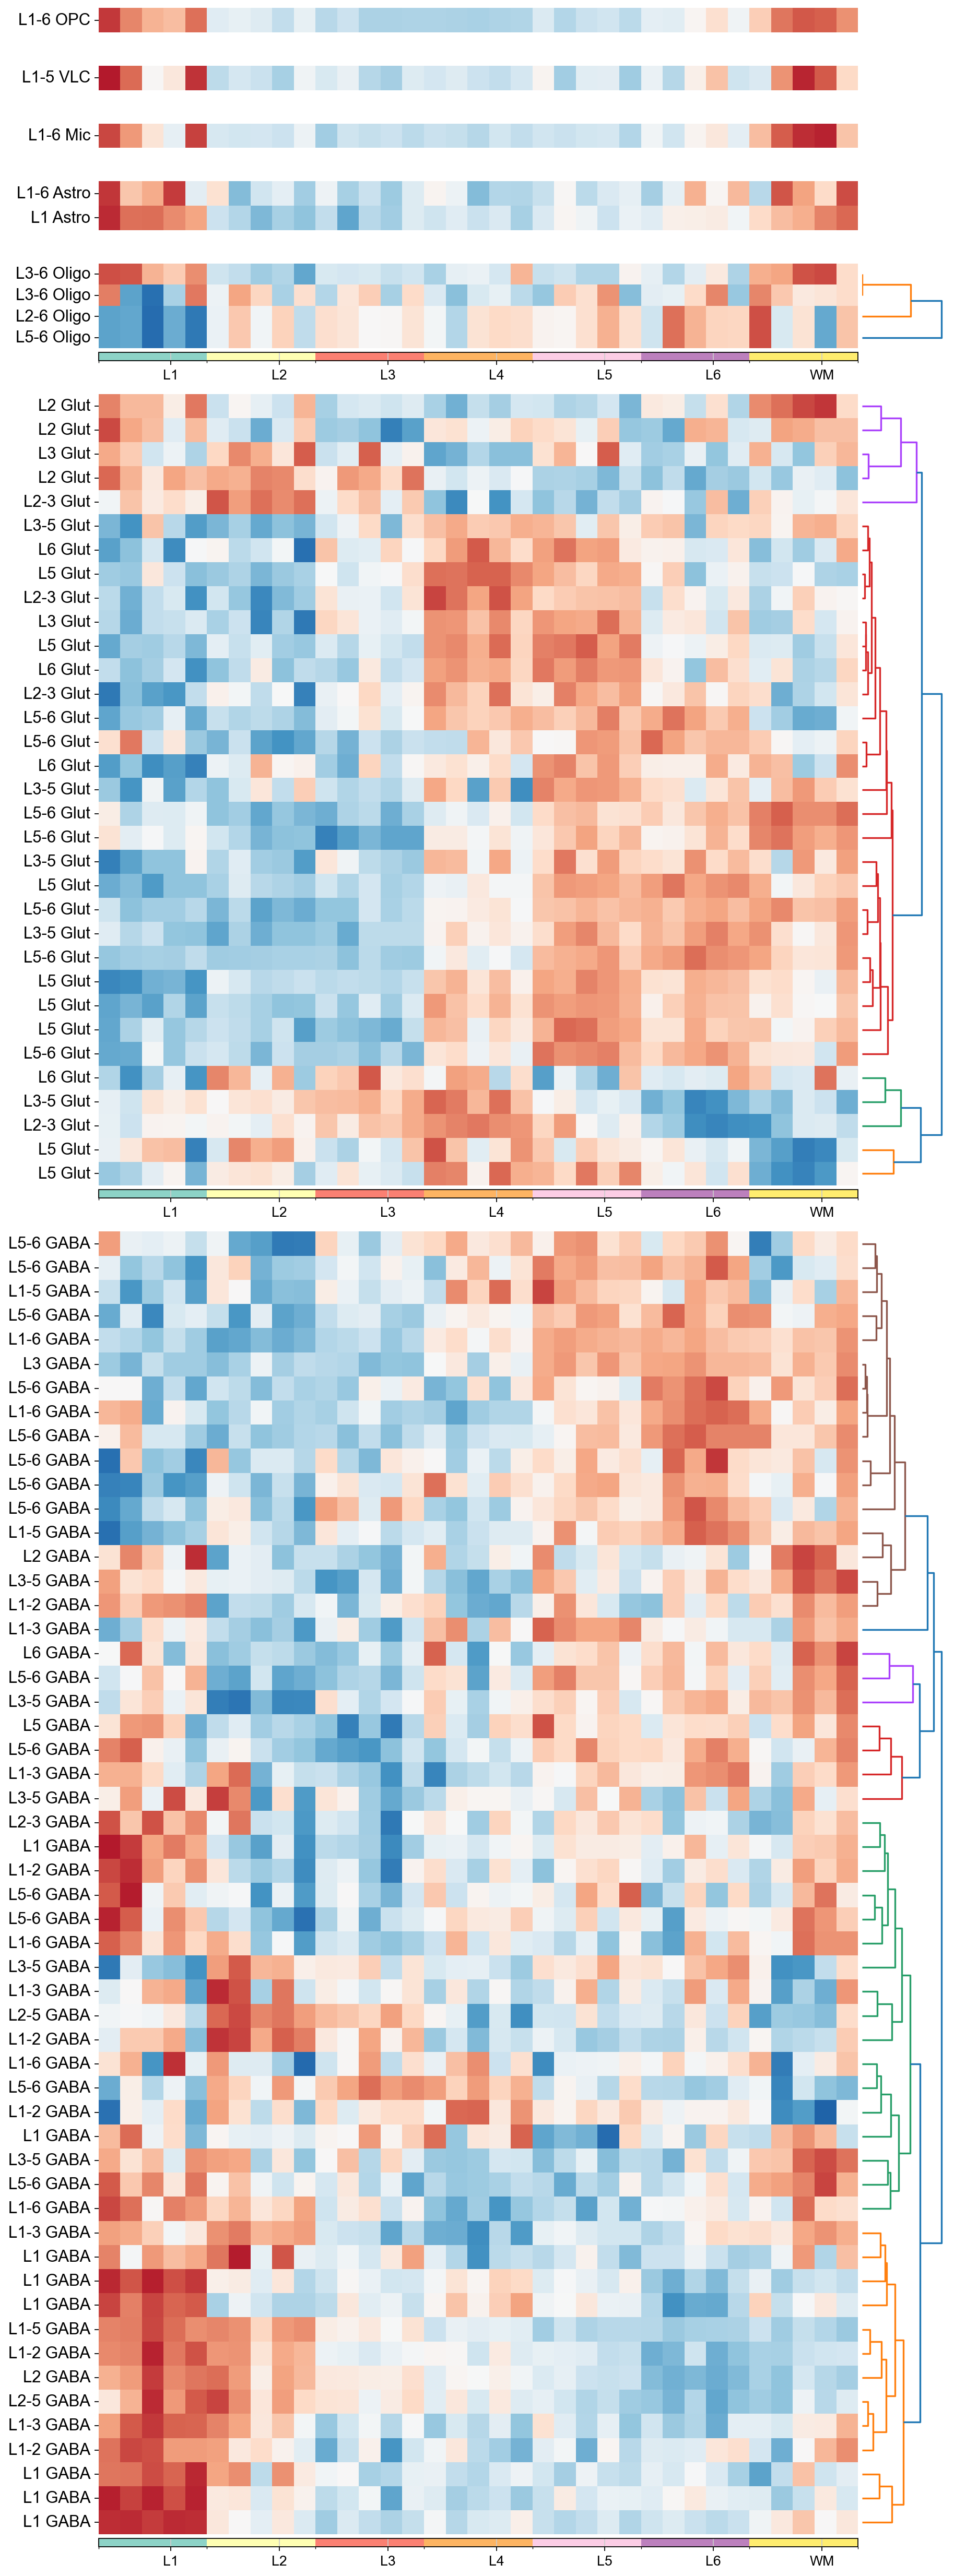

In [42]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from scipy.cluster.hierarchy import average, leaves_list, dendrogram
from scipy.spatial.distance import pdist

cell_type_counts = pca_tr.major_ct.value_counts(ascending=True).to_dict()
fig, axes = plt.subplots(len(cell_type_counts.values()), 1, figsize=(13, 40), height_ratios=cell_type_counts.values(), gridspec_kw={'hspace': 0.1}, dpi=80)

for ct, ax in zip(cell_type_counts.keys(), axes):
    celltype_ord = nes_zscore.columns.str.contains(ct)
    samp_ord = sample_order['human']
    df_sub = nes_zscore.loc[samp_ord, celltype_ord].T.copy()
    if ct in cell_type:
        linkage = average(pdist(df_sub.values, 'cosine'))
        index_ord = leaves_list(linkage)
        sns.heatmap(df_sub.iloc[index_ord, :], ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    else:
        sns.heatmap(df_sub, ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(False)
    ax.tick_params(axis="y", which="major", rotation=0)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size=1, pad=0.05)
    cax.axis('off')

    if ct in cell_type:
        dn = dendrogram(linkage, ax=cax, orientation='right')

        # vertical
        cax = divider.append_axes('bottom', size=0.1, pad=0.05)

        cmap = plt.get_cmap('Set3')
        cond_size = adata_ssgsea[samp_ord].obs.layer.value_counts().loc[layers].values
        cond_pos = cond_size.cumsum()
        bounds = [0] + list(cond_pos)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        fig.colorbar(
            mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
            cax=cax,
            ticks=bounds,
            orientation='horizontal',
            spacing='proportional'
        )

        cax.xaxis.set_major_locator(ticker.FixedLocator(cond_pos - cond_size / 3))
        cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
        cax.set_xticklabels(cax.get_xticklabels(), rotation=0, fontsize=12)
plt.show()

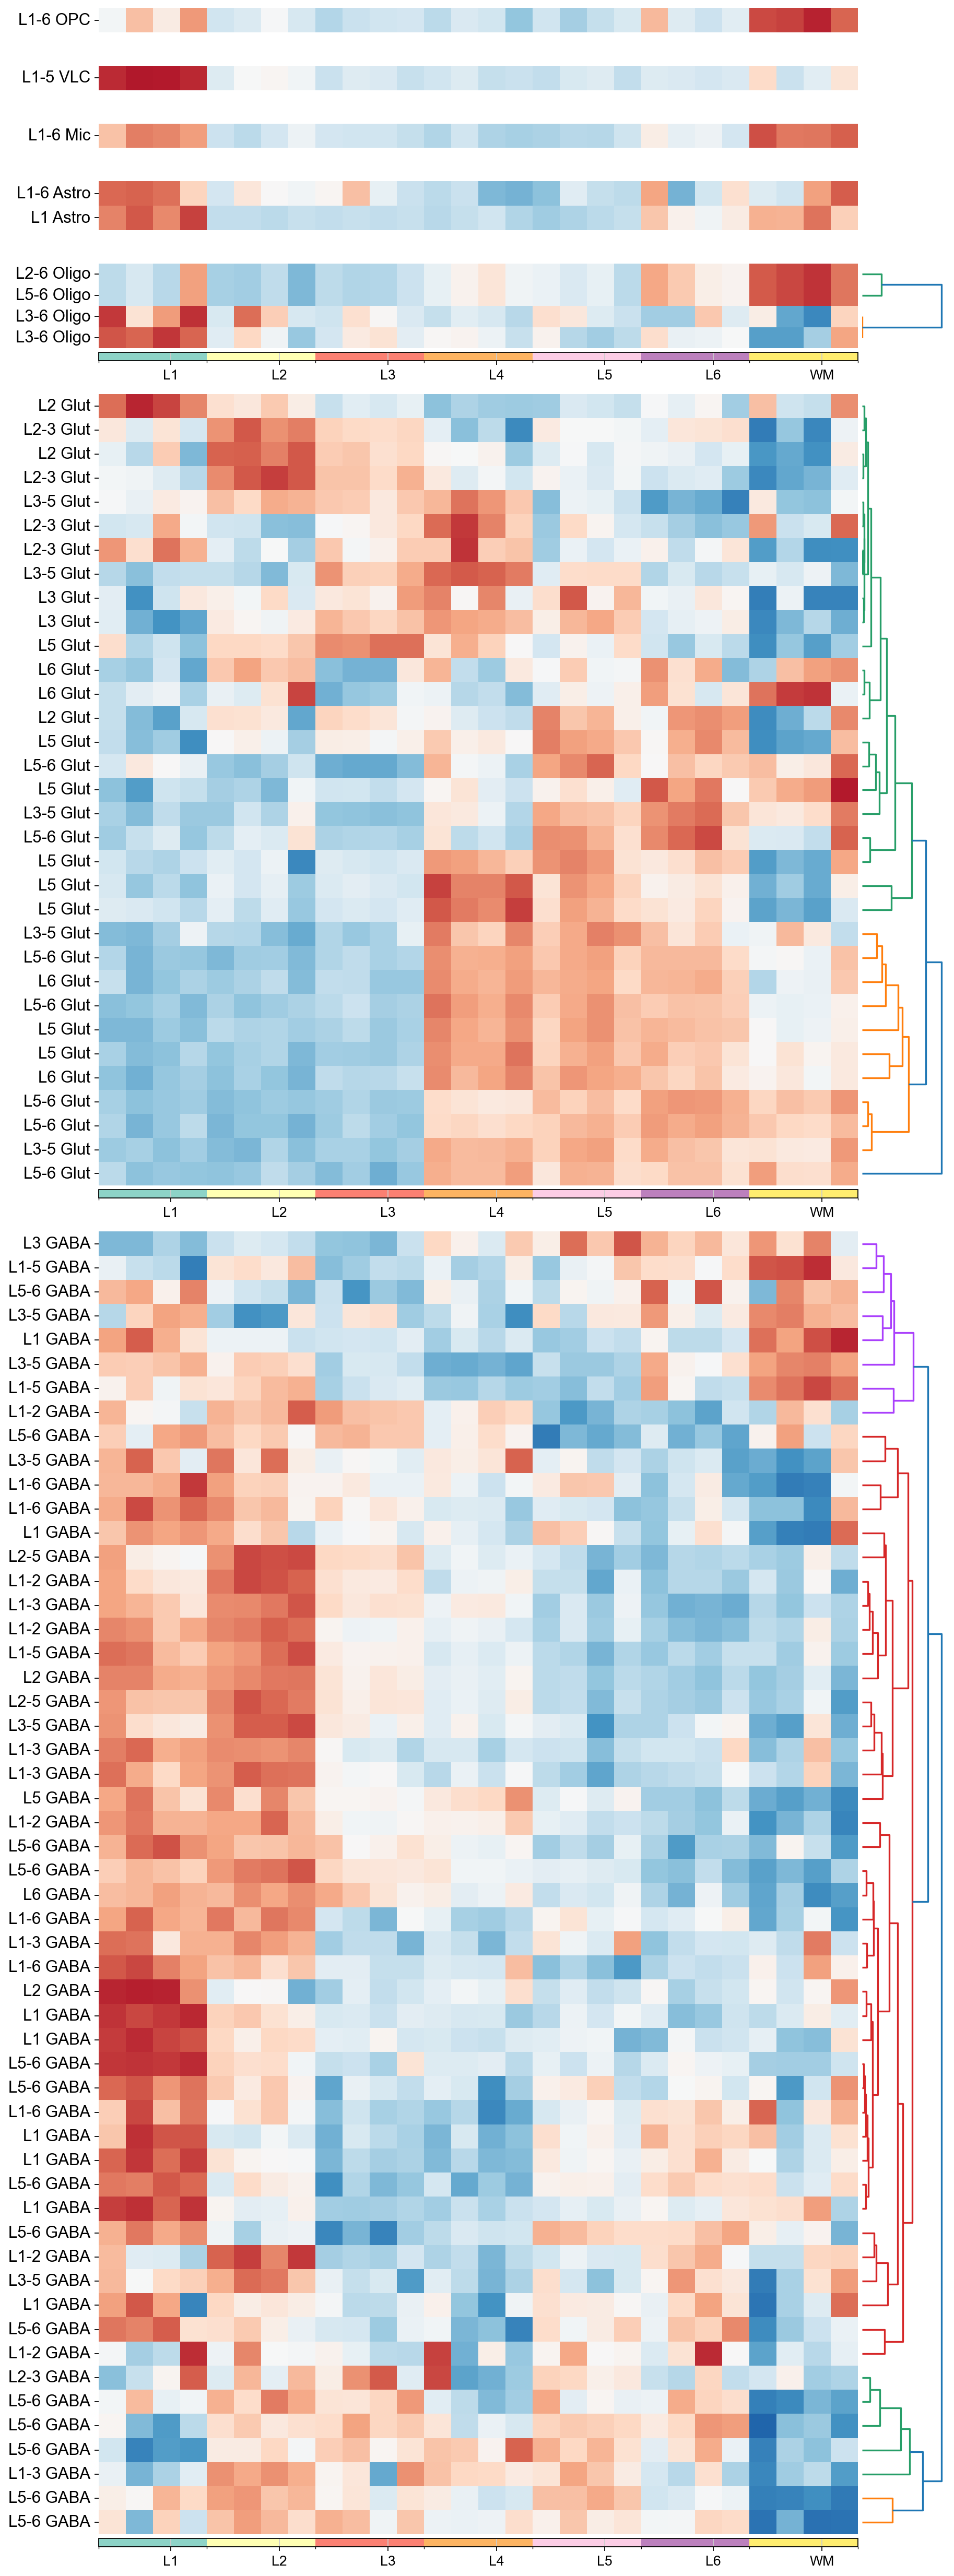

In [43]:
from scipy.cluster.hierarchy import average, leaves_list, dendrogram
from scipy.spatial.distance import pdist

cell_type_counts = pca_tr.major_ct.value_counts(ascending=True).to_dict()
fig, axes = plt.subplots(len(cell_type_counts.values()), 1, figsize=(13, 40), height_ratios=cell_type_counts.values(), gridspec_kw={'hspace': 0.1}, dpi=80)

for ct, ax in zip(cell_type_counts.keys(), axes):
    celltype_ord = nes_zscore.columns.str.contains(ct)
    samp_ord = sample_order['macaque']
    df_sub = nes_zscore.loc[samp_ord, celltype_ord].T.copy()
    #df_sub.index = df_sub.index.map(lambda x: ' '.join(x.split(' ')[1:3]))
    if ct in cell_type:
        linkage = average(pdist(df_sub.values, 'cosine'))
        index_ord = leaves_list(linkage)
        sns.heatmap(df_sub.iloc[index_ord, :], ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    else:
        sns.heatmap(df_sub, ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(False)
    ax.tick_params(axis="y", which="major", rotation=0)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size=1, pad=0.05)
    cax.axis('off')

    if ct in cell_type:
        dn = dendrogram(linkage, ax=cax, orientation='right')

        # vertical
        cax = divider.append_axes('bottom', size=0.1, pad=0.05)

        cmap = plt.get_cmap('Set3')
        cond_size = adata_ssgsea[samp_ord].obs.layer.value_counts().loc[layers].values
        cond_pos = cond_size.cumsum()
        bounds = [0] + list(cond_pos)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        fig.colorbar(
            mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
            cax=cax,
            ticks=bounds,
            orientation='horizontal',
            spacing='proportional'
        )

        cax.xaxis.set_major_locator(ticker.FixedLocator(cond_pos - cond_size / 3))
        cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
        cax.set_xticklabels(cax.get_xticklabels(), rotation=0, fontsize=12)
plt.show()

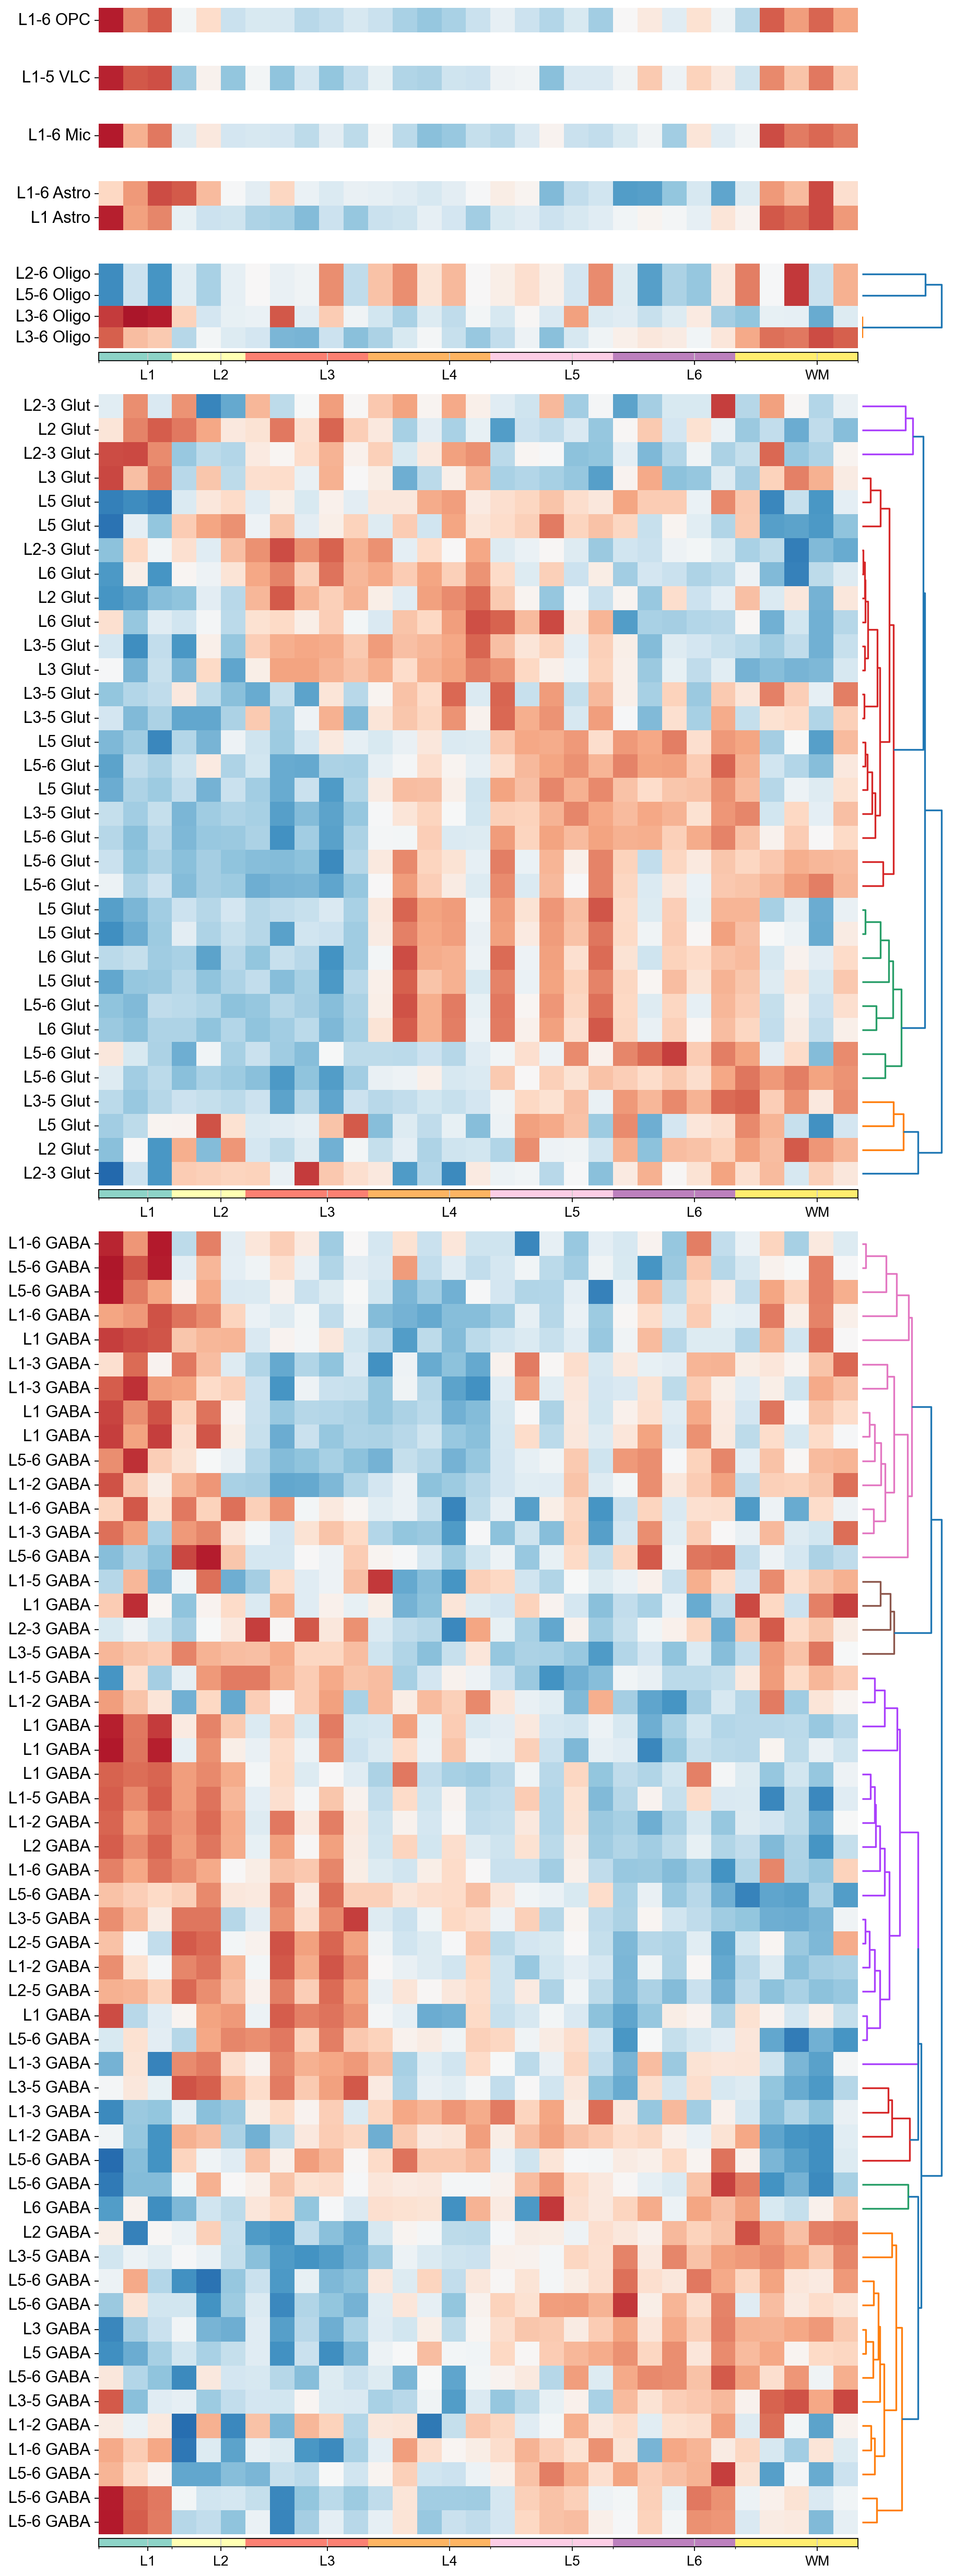

In [44]:
from scipy.cluster.hierarchy import average, leaves_list, dendrogram
from scipy.spatial.distance import pdist

cell_type_counts = pca_tr.major_ct.value_counts(ascending=True).to_dict()
fig, axes = plt.subplots(len(cell_type_counts.values()), 1, figsize=(13, 40), height_ratios=cell_type_counts.values(), gridspec_kw={'hspace': 0.1}, dpi=80)

for ct, ax in zip(cell_type_counts.keys(), axes):
    celltype_ord = nes_zscore.columns.str.contains(ct)
    samp_ord = sample_order['chimp']
    df_sub = nes_zscore.loc[samp_ord, celltype_ord].T.copy()
    #df_sub.index = df_sub.index.map(lambda x: ' '.join(x.split(' ')[1:3]))
    if ct in cell_type:
        linkage = average(pdist(df_sub.values, 'cosine'))
        index_ord = leaves_list(linkage)
        sns.heatmap(df_sub.iloc[index_ord, :], ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    else:
        sns.heatmap(df_sub, ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(False)
    ax.tick_params(axis="y", which="major", rotation=0)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size=1, pad=0.05)
    cax.axis('off')

    if ct in cell_type:
        dn = dendrogram(linkage, ax=cax, orientation='right')

        # vertical
        cax = divider.append_axes('bottom', size=0.1, pad=0.05)

        cmap = plt.get_cmap('Set3')
        cond_size = adata_ssgsea[samp_ord].obs.layer.value_counts().loc[layers].values
        cond_pos = cond_size.cumsum()
        bounds = [0] + list(cond_pos)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        fig.colorbar(
            mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
            cax=cax,
            ticks=bounds,
            orientation='horizontal',
            spacing='proportional'
        )

        cax.xaxis.set_major_locator(ticker.FixedLocator(cond_pos - cond_size / 3))
        cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
        cax.set_xticklabels(cax.get_xticklabels(), rotation=0, fontsize=12)
plt.show()

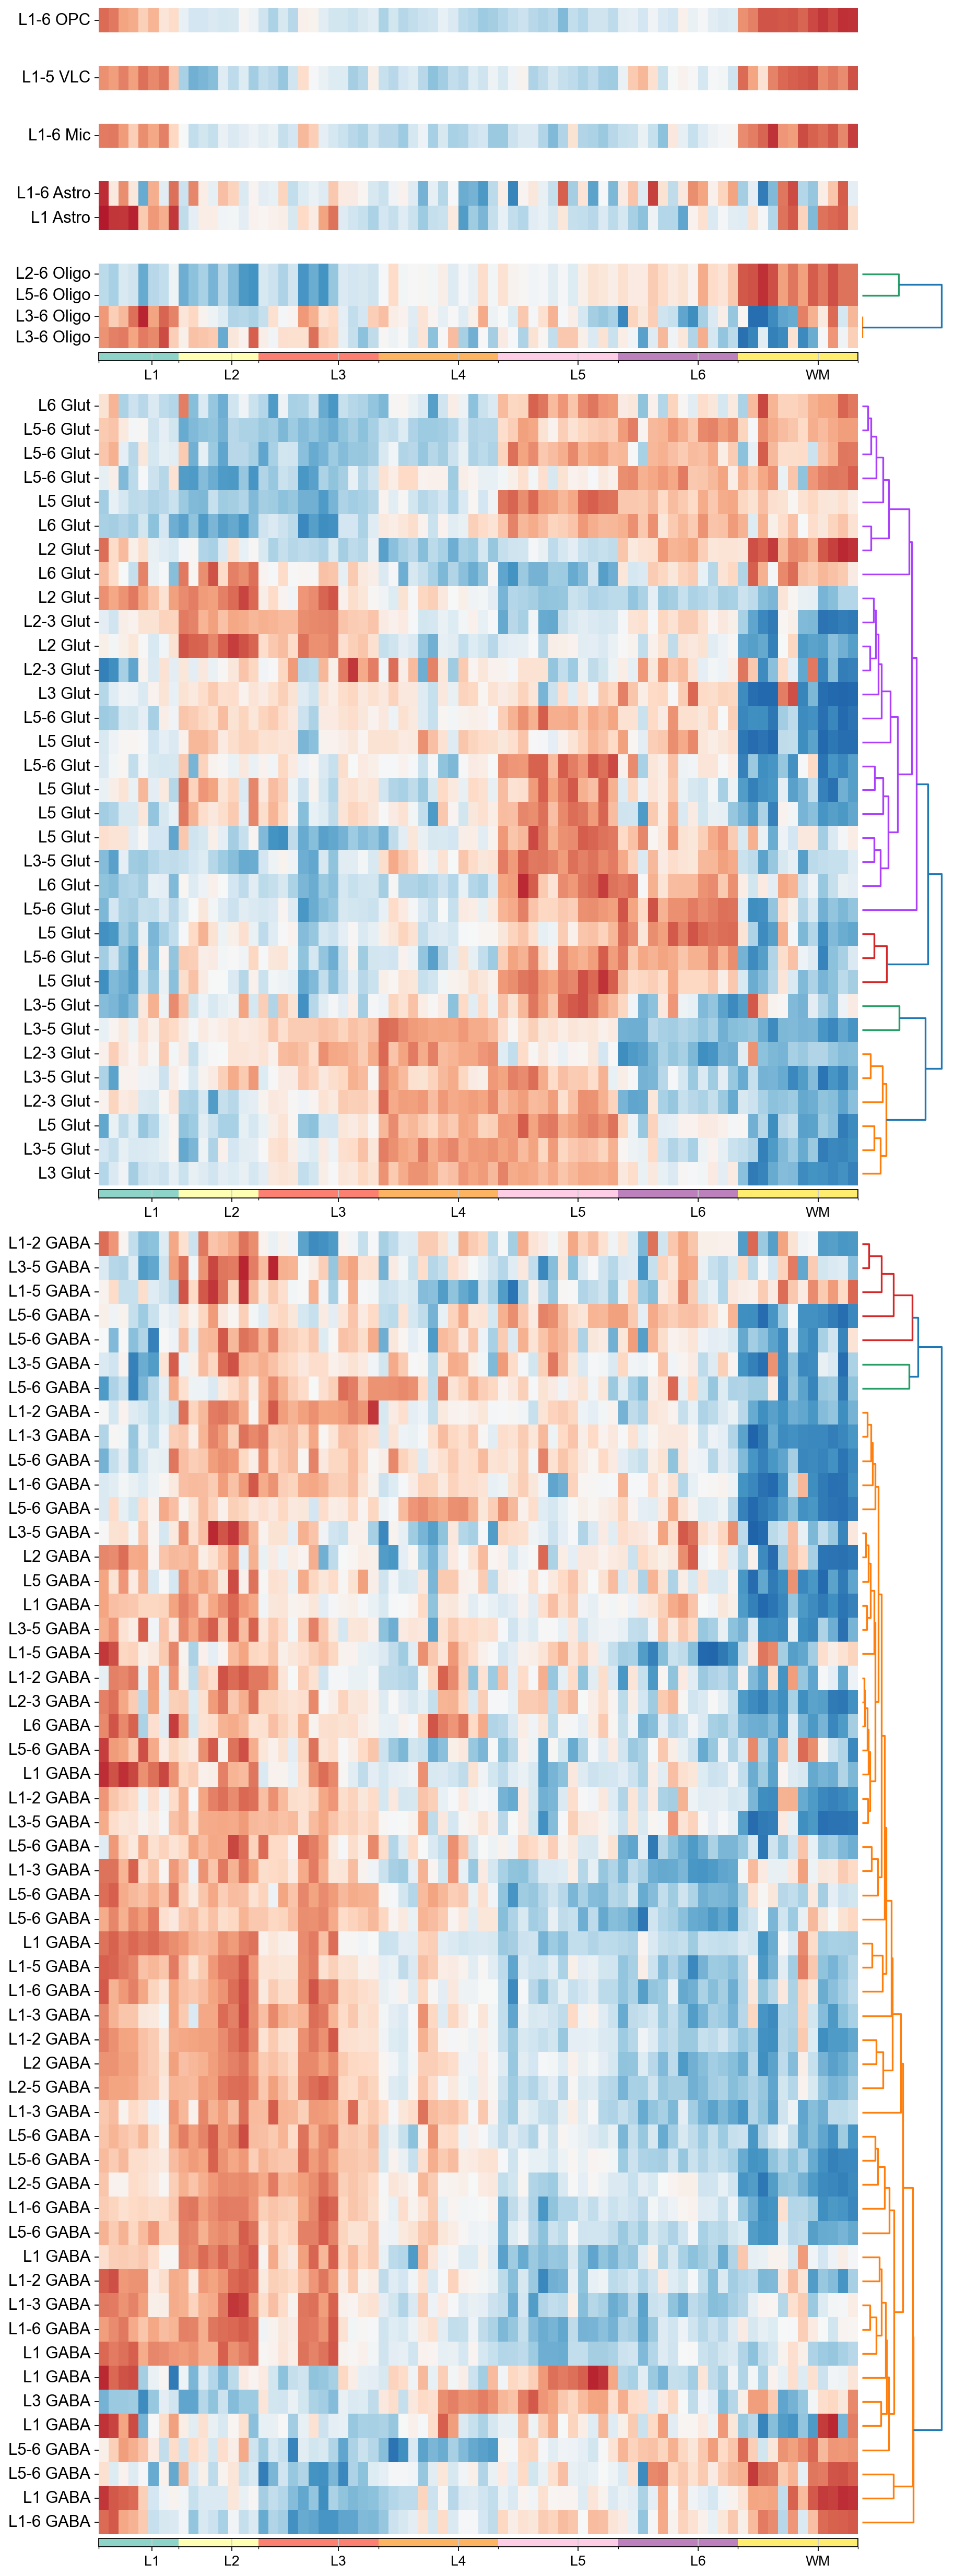

In [45]:
from scipy.cluster.hierarchy import average, leaves_list, dendrogram
from scipy.spatial.distance import pdist

cell_type_counts = pca_tr.major_ct.value_counts(ascending=True).to_dict()
fig, axes = plt.subplots(len(cell_type_counts.values()), 1, figsize=(13, 40), height_ratios=cell_type_counts.values(), gridspec_kw={'hspace': 0.1}, dpi=80)

for ct, ax in zip(cell_type_counts.keys(), axes):
    celltype_ord = nes_zscore.columns.str.contains(ct)
    samp_ord = sample_order['151']
    df_sub = nes_zscore.loc[samp_ord, celltype_ord].T.copy()
    #df_sub.index = df_sub.index.map(lambda x: ' '.join(x.split(' ')[1:3]))
    if ct in cell_type:
        linkage = average(pdist(df_sub.values, 'cosine'))
        index_ord = leaves_list(linkage)
        sns.heatmap(df_sub.iloc[index_ord, :], ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    else:
        sns.heatmap(df_sub, ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(False)
    ax.tick_params(axis="y", which="major", rotation=0)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size=1, pad=0.05)
    cax.axis('off')

    if ct in cell_type:
        dn = dendrogram(linkage, ax=cax, orientation='right')

        # vertical
        cax = divider.append_axes('bottom', size=0.1, pad=0.05)

        cmap = plt.get_cmap('Set3')
        cond_size = adata_ssgsea[samp_ord].obs.layer.value_counts().loc[layers].values
        cond_pos = cond_size.cumsum()
        bounds = [0] + list(cond_pos)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        fig.colorbar(
            mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
            cax=cax,
            ticks=bounds,
            orientation='horizontal',
            spacing='proportional'
        )

        cax.xaxis.set_major_locator(ticker.FixedLocator(cond_pos - cond_size / 3))
        cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
        cax.set_xticklabels(cax.get_xticklabels(), rotation=0, fontsize=12)
plt.show()

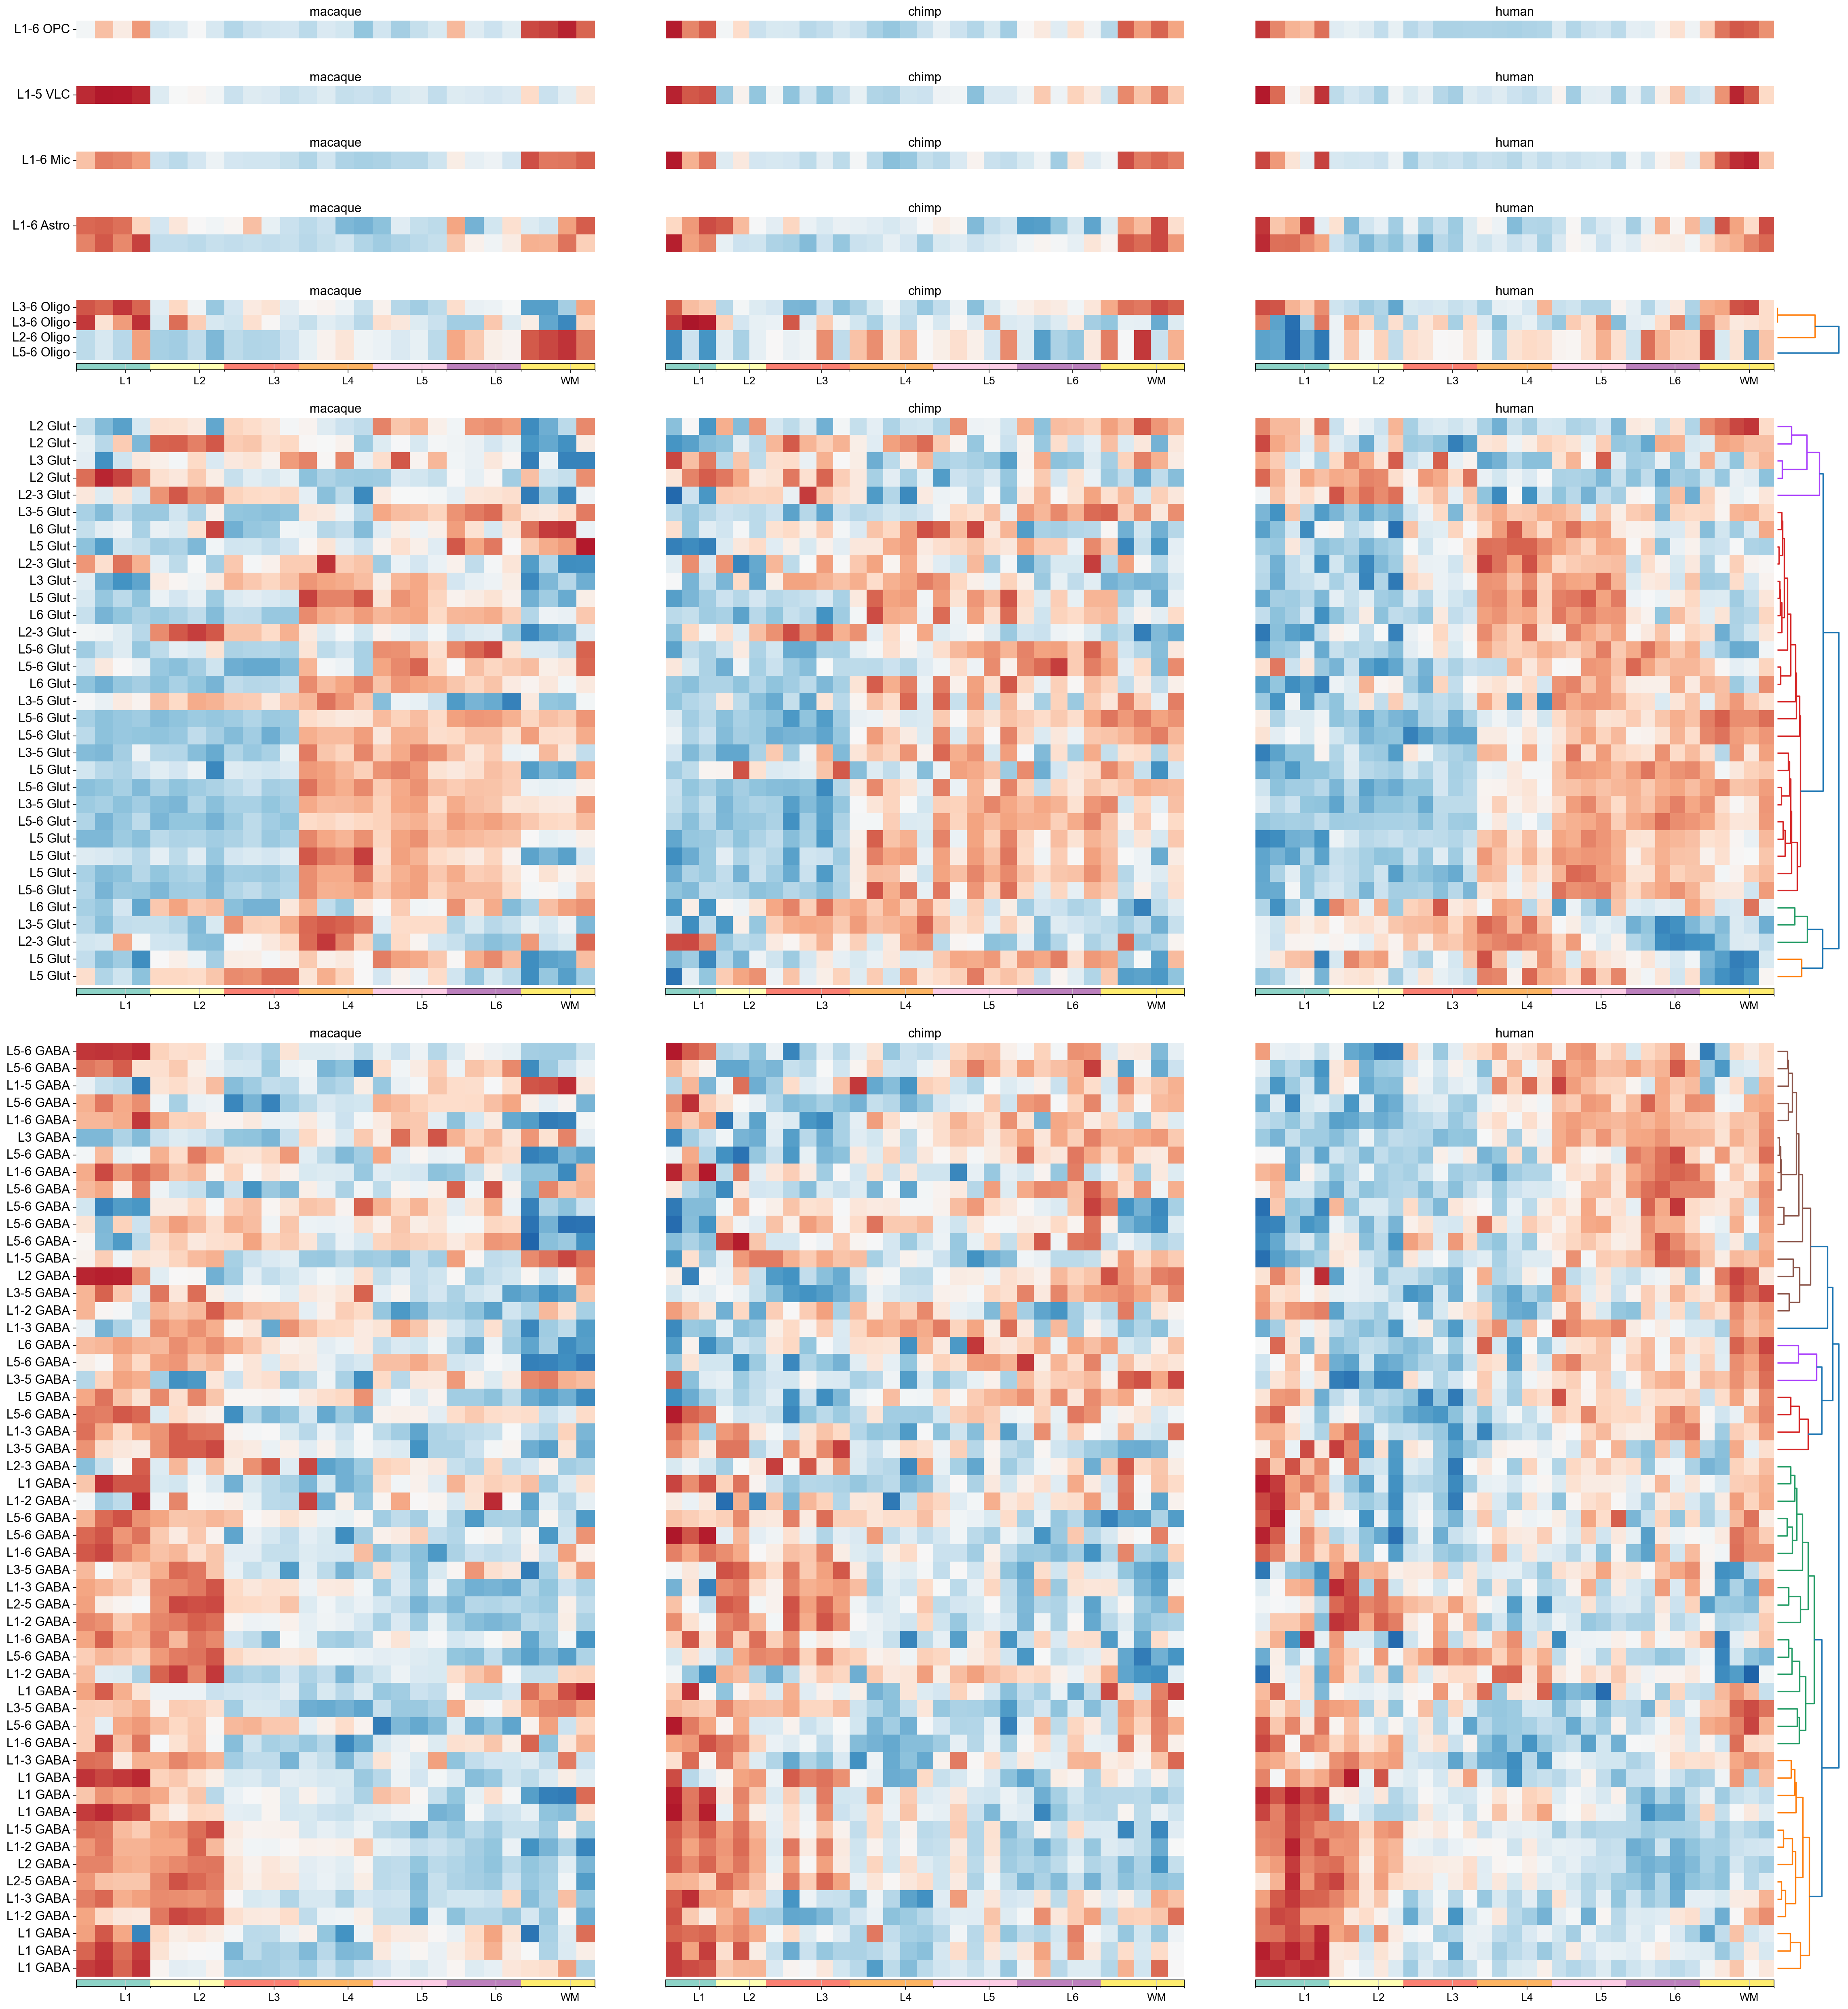

In [46]:
from scipy.cluster.hierarchy import average, leaves_list, dendrogram
from scipy.spatial.distance import pdist

cell_type_counts = pca_tr.major_ct.value_counts(ascending=True).to_dict()
fig, axes = plt.subplots(len(cell_type_counts.values()), 3, figsize=(35, 40), height_ratios=cell_type_counts.values(), gridspec_kw={'hspace': 0.2, 'wspace': 0.005}, dpi=80)


for j, ct in enumerate(cell_type_counts.keys()):
    for sp, ax in zip(['human', 'chimp', 'macaque'], axes[j, :][::-1]):
        celltype_ord = nes_zscore.columns.str.contains(ct)
        samp_ord = sample_order[sp]
        df_sub = nes_zscore.loc[samp_ord, celltype_ord].T.copy()
        #df_sub.index = df_sub.index.map(lambda x: ' '.join(x.split(' ')[1:3]))
        if ct in cell_type:
            if sp == 'human':
                linkage = average(pdist(df_sub.values, 'cosine'))
                index_ord = leaves_list(linkage)
            sns.heatmap(df_sub.iloc[index_ord, :], ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
        else:
            sns.heatmap(df_sub, ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
        ax.set_title(sp)
        if sp != 'macaque':
            ax.set_yticks([])
        ax.set_xticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.grid(False)
        ax.tick_params(axis="y", which="major", rotation=0)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size=1, pad=0.05)
        cax.axis('off')

        if ct in cell_type:
            if sp == 'human':
                dn = dendrogram(linkage, ax=cax, orientation='right')

            # vertical
            cax = divider.append_axes('bottom', size=0.1, pad=0.05)

            cmap = plt.get_cmap('Set3')
            cond_size = adata_ssgsea[samp_ord].obs.layer.value_counts().loc[layers].values
            cond_pos = cond_size.cumsum()
            bounds = [0] + list(cond_pos)
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

            fig.colorbar(
                mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
                cax=cax,
                ticks=bounds,
                orientation='horizontal',
                spacing='proportional'
            )

            cax.xaxis.set_major_locator(ticker.FixedLocator(cond_pos - cond_size / 3))
            cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
            cax.set_xticklabels(cax.get_xticklabels(), rotation=0, fontsize=12)
plt.show()

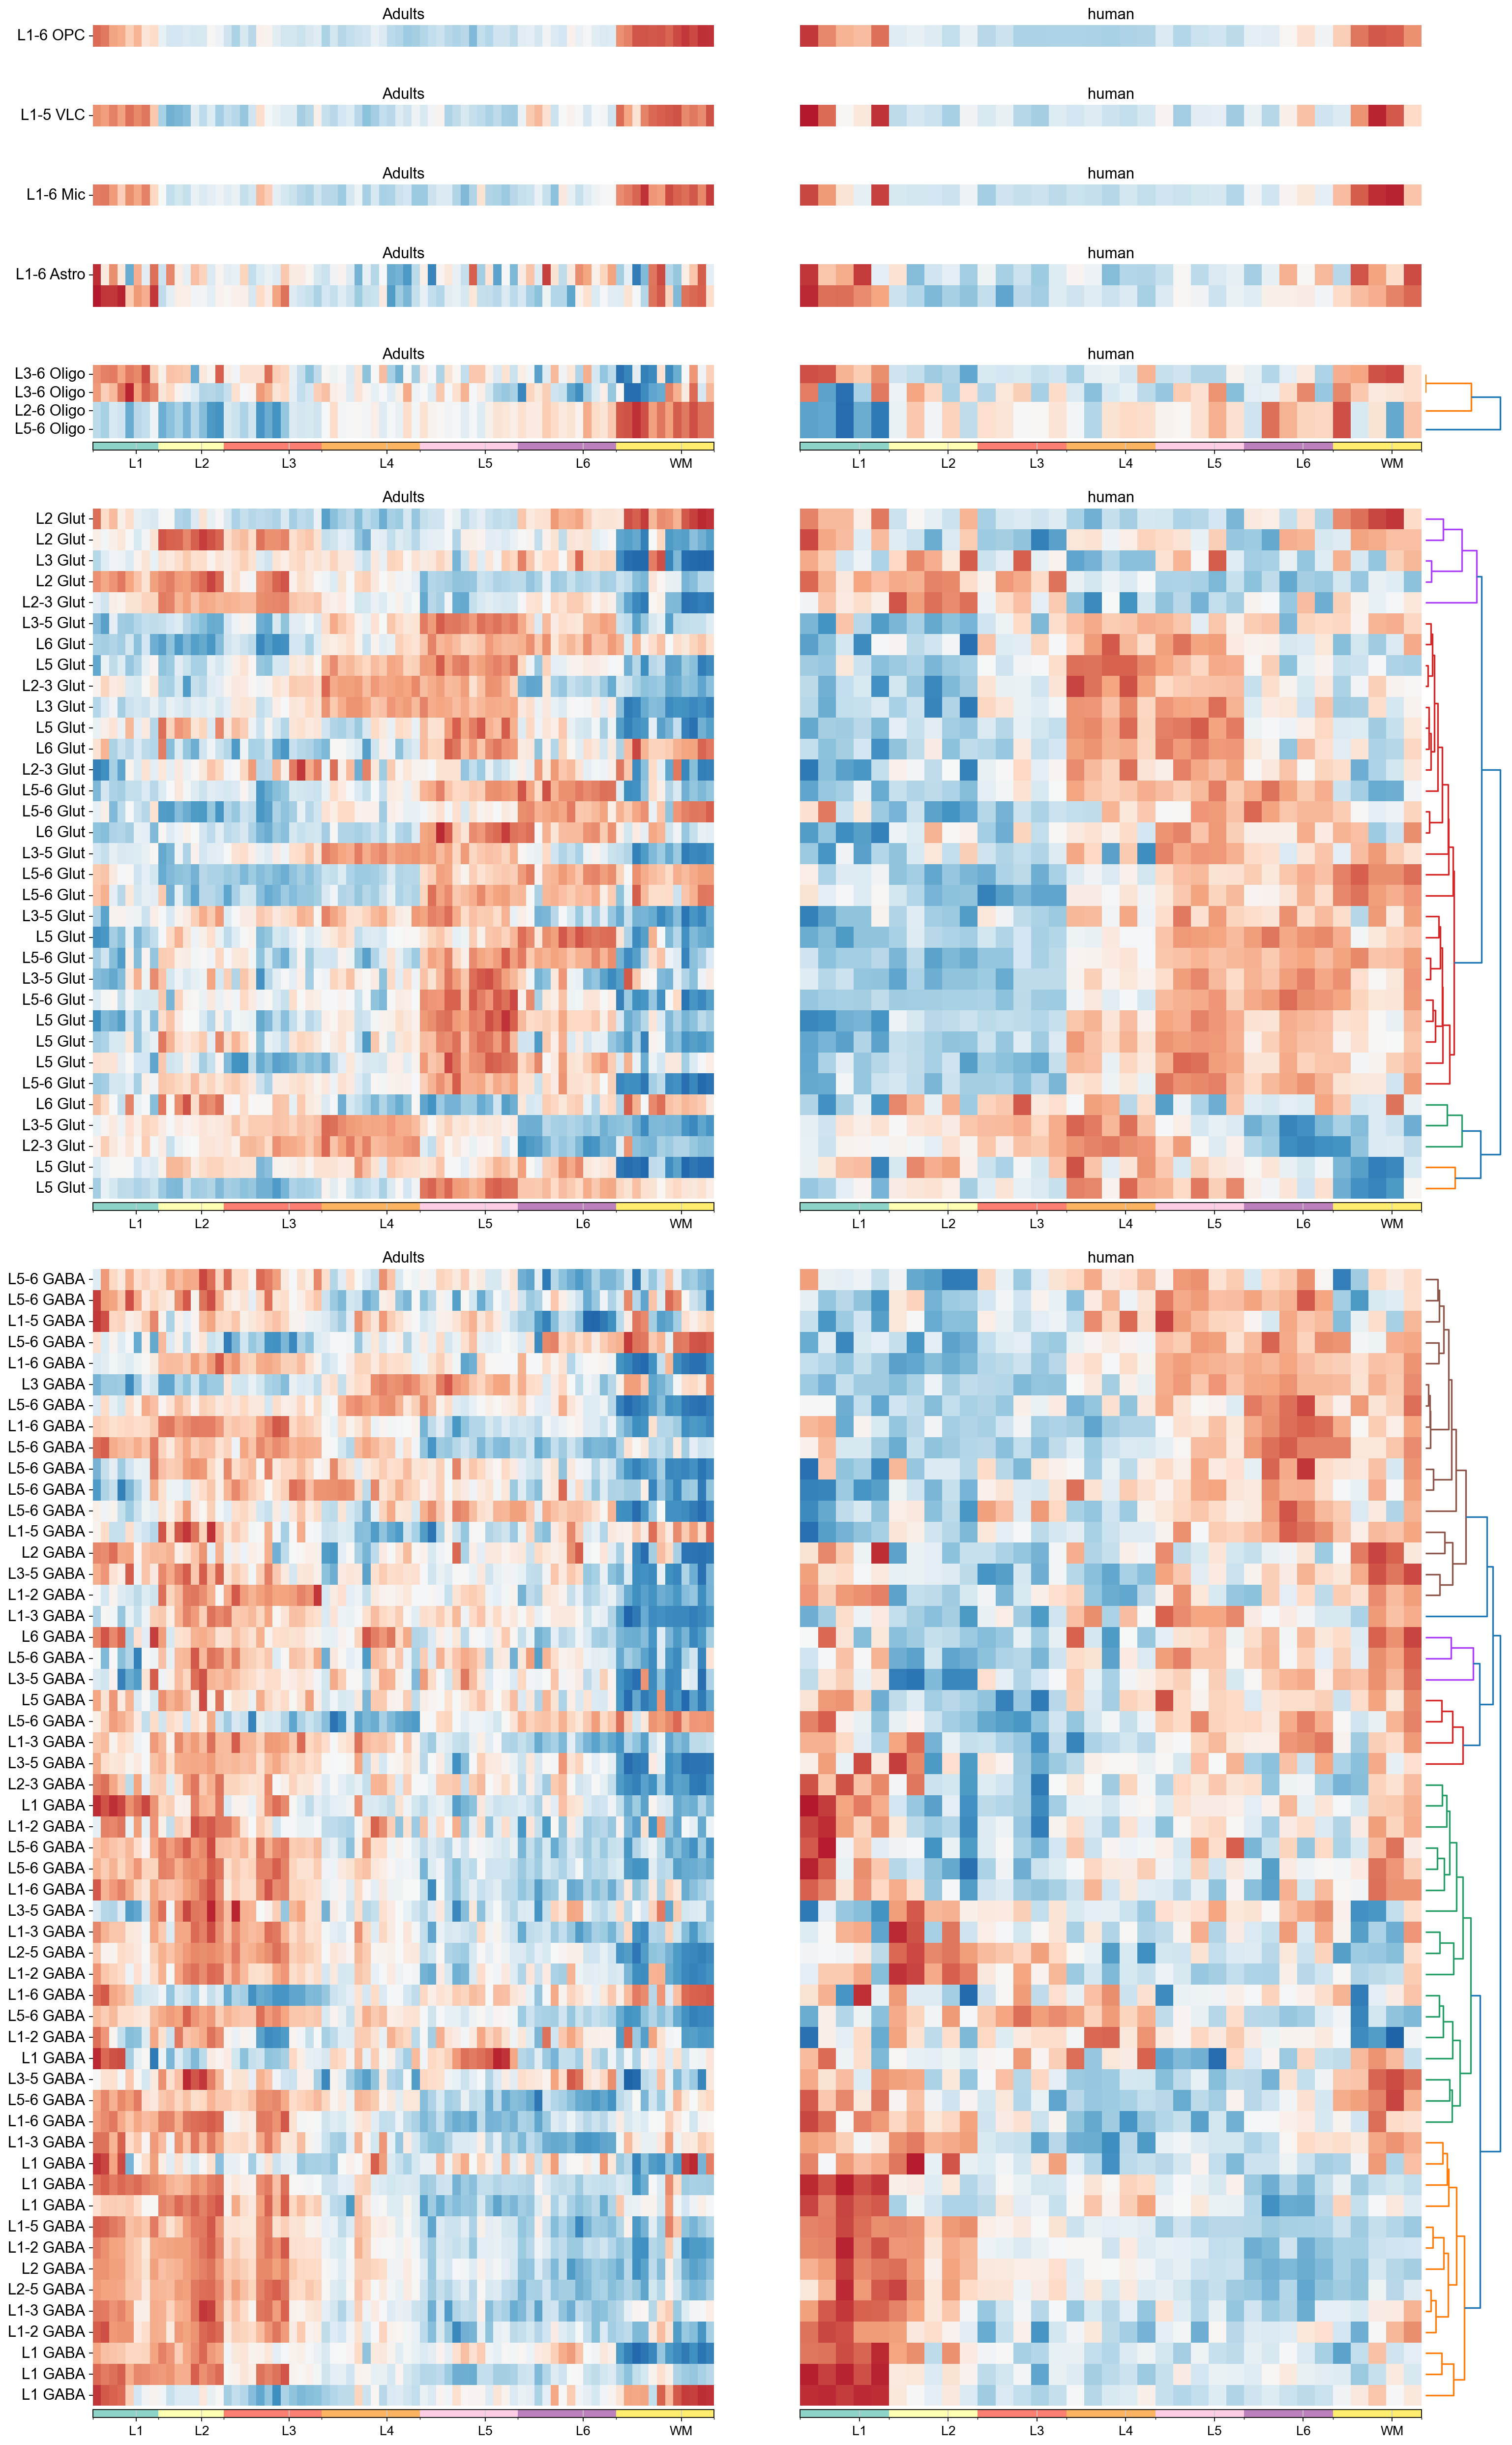

In [47]:
from scipy.cluster.hierarchy import average, leaves_list, dendrogram
from scipy.spatial.distance import pdist

cell_type_counts = pca_tr.major_ct.value_counts(ascending=True).to_dict()
fig, axes = plt.subplots(len(cell_type_counts.values()), 2, figsize=(23, 40), height_ratios=cell_type_counts.values(), gridspec_kw={'hspace': 0.2, 'wspace': 0.005}, dpi=80)


for j, ct in enumerate(cell_type_counts.keys()):
    for sp, ax in zip(['human', '151'], axes[j, :][::-1]):
        celltype_ord = nes_zscore.columns.str.contains(ct)
        samp_ord = sample_order[sp]
        df_sub = nes_zscore.loc[samp_ord, celltype_ord].T.copy()
        #df_sub.index = df_sub.index.map(lambda x: ' '.join(x.split(' ')[1:3]))
        if ct in cell_type:
            if sp == 'human':
                linkage = average(pdist(df_sub.values, 'cosine'))
                index_ord = leaves_list(linkage)
            sns.heatmap(df_sub.iloc[index_ord, :], ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
        else:
            sns.heatmap(df_sub, ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
        if sp != '151':
            ax.set_yticks([])
            ax.set_title(sp)
        else:
            ax.set_title('Adults')
        ax.set_xticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.grid(False)
        ax.tick_params(axis="y", which="major", rotation=0)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size=1, pad=0.05)
        cax.axis('off')

        if ct in cell_type:
            if sp == 'human':
                dn = dendrogram(linkage, ax=cax, orientation='right')

            # vertical
            cax = divider.append_axes('bottom', size=0.1, pad=0.05)

            cmap = plt.get_cmap('Set3')
            cond_size = adata_ssgsea[samp_ord].obs.layer.value_counts().loc[layers].values
            cond_pos = cond_size.cumsum()
            bounds = [0] + list(cond_pos)
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

            fig.colorbar(
                mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
                cax=cax,
                ticks=bounds,
                orientation='horizontal',
                spacing='proportional'
            )

            cax.xaxis.set_major_locator(ticker.FixedLocator(cond_pos - cond_size / 3))
            cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
            cax.set_xticklabels(cax.get_xticklabels(), rotation=0, fontsize=12)
plt.show()